# Обучение моделей детекции автотранспорта

Этот ноутбук реализует ML-компонент согласно спецификации `SPECIFICATION_ML.md`.

## Цели:
1. Детекция 7 классов автотранспорта
2. Обеспечение скорости обработки < 5 минут на изображение
3. Поддержка минимум 2 моделей для выбора пользователем
4. Интеграция с backend и frontend

## Архитектура:
- Основная модель: YOLOv8 (ultralytics)
- Сравниваемые модели: YOLOv8n, YOLOv8m, YOLOv8l
- Альтернативы: YOLOv9, YOLO11 (опционально)

## Датасеты:
1. VisDrone Dataset
2. OpenImages V7

# 1. Установка зависимостей

In [1]:
# Установка необходимых библиотек
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade ultralytics
!pip install opencv-python pandas numpy matplotlib seaborn scikit-learn
!pip install roboflow kagglehub
!pip install onnx onnxruntime

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# Импорт библиотек
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import yaml
import json
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Ultralytics YOLO
from ultralytics import YOLO
from ultralytics.utils.metrics import ConfusionMatrix
from ultralytics.utils.plotting import Annotator

# Настройка отображения
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Проверка доступности GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3090
CUDA version: 11.8


# 2. Подготовка данных

In [3]:
# Создание структуры директорий
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

datasets_dir = data_dir / "datasets"
datasets_dir.mkdir(exist_ok=True)

models_dir = data_dir / "models"
models_dir.mkdir(exist_ok=True)

results_dir = data_dir / "results"
results_dir.mkdir(exist_ok=True)

print("Структура директорий создана:")
for path in data_dir.rglob("*"):
    if path.is_dir():
        print(f"  {path.relative_to(data_dir.parent)}")

Структура директорий создана:
  data/models
  data/datasets
  data/results
  data/datasets/visdrone
  data/results/yolov8n
  data/datasets/visdrone/VisDrone2019-DET-test-challenge
  data/datasets/visdrone/VisDrone2019-DET-train
  data/datasets/visdrone/VisDrone2019-DET-test-dev
  data/datasets/visdrone/VisDrone2019-DET-val
  data/datasets/visdrone/VisDrone2019-DET-test-challenge/VisDrone2019-DET-test-challenge
  data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train
  data/datasets/visdrone/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev
  data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val
  data/datasets/visdrone/VisDrone2019-DET-test-challenge/VisDrone2019-DET-test-challenge/images
  data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/annotations
  data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/images
  data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/labels
  data/datasets/visdrone/VisDrone201

In [4]:
from pathlib import Path
import os

print("os.getcwd():", os.getcwd())
print("Path.cwd():", Path.cwd())
print("data absolute:", (Path("data")).resolve())

os.getcwd(): /home/artem
Path.cwd(): /home/artem
data absolute: /home/artem/data


In [5]:
from pathlib import Path

# Базовая директория проекта = текущая рабочая директория ноутбука
# (у вас по логам это: ...\src\ml_module)
PROJECT_DIR = Path.cwd()

DATA_DIR = PROJECT_DIR / "data"
datasets_dir = DATA_DIR / "datasets"   # <- то, чего не хватало
models_dir = DATA_DIR / "models"
results_dir = DATA_DIR / "results"

for p in (datasets_dir, models_dir, results_dir):
    p.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("datasets_dir:", datasets_dir.resolve())

PROJECT_DIR: /home/artem
datasets_dir: /home/artem/data/datasets


In [6]:
# Загрузка VisDrone Dataset (пример - требуется настройка с Kaggle API)

# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files(
#     "kushagrapandya/visdrone-dataset",
#     path=str(datasets_dir / "visdrone"),
#     unzip=True,
# )

In [6]:
from pathlib import Path

# Базовые директории (под ваш проект)
PROJECT_DIR = Path.cwd()  # .../src/ml_module
DATA_DIR = PROJECT_DIR / "data"
DATASETS_DIR = DATA_DIR / "datasets"

# VisDrone (как у вас в дереве проекта)
VISDRONE_DIR = DATASETS_DIR / "visdrone"
train_root = VISDRONE_DIR / "VisDrone2019-DET-train" / "VisDrone2019-DET-train"
val_root = VISDRONE_DIR / "VisDrone2019-DET-val" / "VisDrone2019-DET-val"

# Переменные, которые у вас используются дальше
train_img_dir = train_root / "images"
train_ann_dir = train_root / "annotations"
val_img_dir = val_root / "images"
val_ann_dir = val_root / "annotations"

# Проверка, чтобы ошибка была понятной сразу
paths = {
    "train_img_dir": train_img_dir,
    "train_ann_dir": train_ann_dir,
    "val_img_dir": val_img_dir,
    "val_ann_dir": val_ann_dir,
}

missing = [name for name, p in paths.items() if not p.exists()]
if missing:
    details = "\n".join(f"- {name}: {paths[name]}" for name in missing)
    raise FileNotFoundError(
        "Не найдены ожидаемые папки датасета VisDrone.\n"
        "Проверьте текущую рабочую директорию (Path.cwd()) и структуру data/datasets.\n"
        f"Отсутствуют:\n{details}"
    )

print("OK:")
for name, p in paths.items():
    print(f" {name}: {p}")

OK:
 train_img_dir: /home/artem/data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/images
 train_ann_dir: /home/artem/data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/annotations
 val_img_dir: /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/images
 val_ann_dir: /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/annotations


train images: /home/artem/data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/images
train ann: /home/artem/data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/annotations


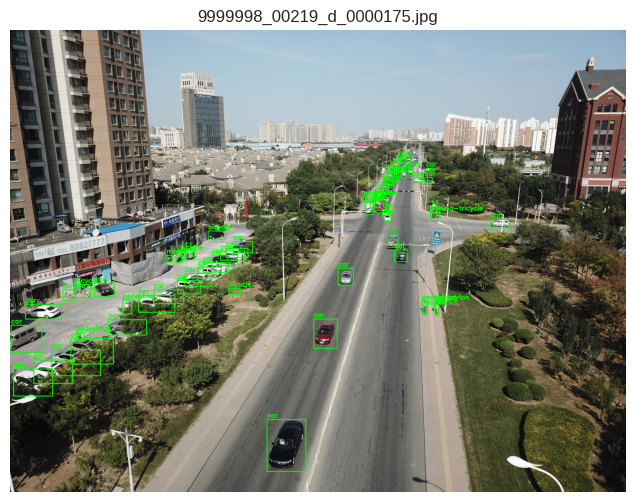

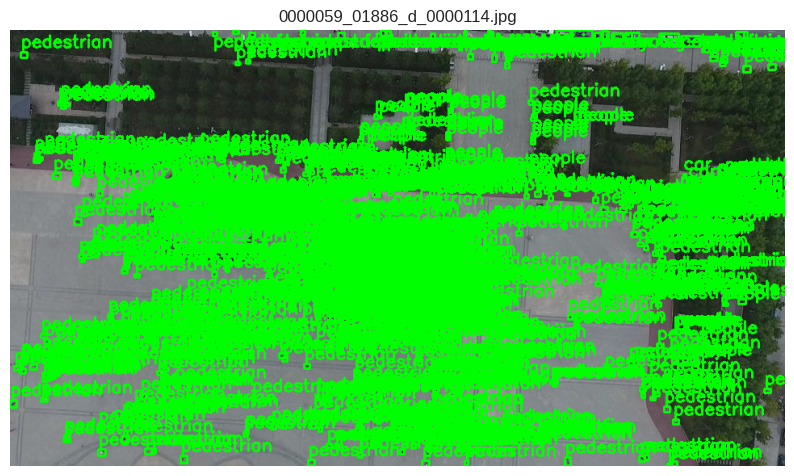

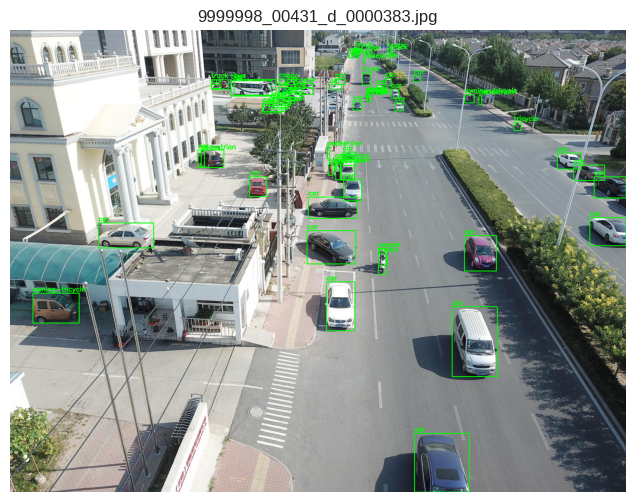

In [7]:
from pathlib import Path
import random
import cv2
import matplotlib.pyplot as plt

# 1) Пути (у тебя они уже есть: train_img_dir, train_ann_dir, val_img_dir, val_ann_dir)
# Проверим на всякий:
print("train images:", train_img_dir)
print("train ann:", train_ann_dir)

# 2) Имена классов VisDrone (как в yaml): 1..10, где 0 = ignored regions
visdrone_names = {
    1: "pedestrian",
    2: "people",
    3: "bicycle",
    4: "car",
    5: "van",
    6: "truck",
    7: "tricycle",
    8: "awning-tricycle",
    9: "bus",
    10: "motor",
}

def show_visdrone_samples(images_dir: Path, ann_dir: Path, n: int = 3):
    img_files = sorted([p for p in images_dir.glob("*.*") if p.suffix.lower() in {".jpg", ".png", ".jpeg"}])
    if not img_files:
        raise FileNotFoundError(f"Нет изображений в {images_dir.resolve()}")

    for img_path in random.sample(img_files, k=min(n, len(img_files))):
        ann_path = ann_dir / f"{img_path.stem}.txt"

        img = cv2.imread(str(img_path))
        if img is None:
            print("Не прочиталось изображение:", img_path)
            continue

        # Рисуем bbox'ы, если есть аннотация
        if ann_path.exists():
            with open(ann_path, "r", encoding="utf-8") as f:
                for line in f:
                    parts = line.strip().split(",")
                    if len(parts) < 6:
                        continue

                    x, y, w, h = map(int, parts[:4])
                    score = parts[4].strip()          # иногда -1/0/1, для GT может быть "1"
                    cls_id = int(parts[5].strip())    # 0..10 (0 = ignore)

                    if cls_id == 0:  # ignored regions
                        continue

                    name = visdrone_names.get(cls_id, str(cls_id))
                    x1, y1, x2, y2 = x, y, x + w, y + h
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, name, (x1, max(20, y1 - 6)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.title(img_path.name)
        plt.axis("off")
        plt.imshow(img_rgb)
        plt.show()

# Покажем примеры
show_visdrone_samples(train_img_dir, train_ann_dir, n=3)

In [8]:
from pathlib import Path
import cv2

train_root = Path(r"C:\Users\Artem\PycharmProjects\dls-detection\src\ml_module\data\datasets\visdrone\VisDrone2019-DET-train\VisDrone2019-DET-train")
val_root   = Path(r"C:\Users\Artem\PycharmProjects\dls-detection\src\ml_module\data\datasets\visdrone\VisDrone2019-DET-val\VisDrone2019-DET-val")

def visdrone_to_yolo_labels(split_root: Path):
    images_dir = split_root / "images"
    ann_dir = split_root / "annotations"
    labels_dir = split_root / "labels"
    labels_dir.mkdir(parents=True, exist_ok=True)

    for ann_path in sorted(ann_dir.glob("*.txt")):
        # картинка по stem (обычно .jpg)
        img_path = (images_dir / ann_path.name).with_suffix(".jpg")
        if not img_path.exists():
            cands = list(images_dir.glob(ann_path.stem + ".*"))
            if not cands:
                continue
            img_path = cands[0]

        img = cv2.imread(str(img_path))
        if img is None:
            continue
        h_img, w_img = img.shape[:2]

        out_lines = []
        for line in ann_path.read_text(encoding="utf-8").splitlines():
            parts = [x.strip() for x in line.split(",")]
            if len(parts) < 6:
                continue

            x, y, w, h = map(float, parts[:4])
            cls_vis = int(parts[5])

            # ignore regions
            if cls_vis == 0:
                continue

            cls = cls_vis - 1  # 1..10 -> 0..9

            xc = (x + w / 2) / w_img
            yc = (y + h / 2) / h_img
            wn = w / w_img
            hn = h / h_img
            if wn <= 0 or hn <= 0:
                continue

            out_lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

        (labels_dir / f"{ann_path.stem}.txt").write_text(
            "\n".join(out_lines) + ("\n" if out_lines else ""),
            encoding="utf-8"
        )

visdrone_to_yolo_labels(train_root)
visdrone_to_yolo_labels(val_root)

print("Готово: labels созданы рядом с images/annotations.")

Готово: labels созданы рядом с images/annotations.


# 3. Обучение моделей

In [9]:
# Конфигурация обучения
training_configs = {
    'yolov8n': {
        'model': 'yolov8n.pt',
        'epochs': 50,
        'imgsz': 1024,
        'batch': 10,
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
    },
    'yolov8m': {
        'model': 'yolov8m.pt',
        'epochs': 50,
        'imgsz': 1024,
        'batch': 8,
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
    },
    'yolov8l': {
        'model': 'yolov8l.pt',
        'epochs': 50,
        'imgsz': 1024,
        'batch': 4,
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
    }
}

# Эксперименты с гиперпараметрами (для тюнинга)
hyperparameter_experiments = {
    'exp1': {'imgsz': 1024, 'lr0': 0.001, 'batch': 4},
    'exp2': {'imgsz': 640, 'lr0': 0.01, 'batch': 8, 'augment': True},
    'exp3': {'imgsz': 640, 'lr0': 0.005, 'batch': 16, 'label_smoothing': 0.1},
}

In [10]:
import logging
from pathlib import Path
from datetime import datetime
import time


def make_train_logger(run_name: str, logs_dir: str | Path = "logs") -> logging.Logger:
    logs_dir = Path(logs_dir)
    logs_dir.mkdir(parents=True, exist_ok=True)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_path = logs_dir / f"{run_name}_{ts}.log"

    logger = logging.getLogger(f"train.{run_name}.{ts}")
    logger.setLevel(logging.INFO)
    logger.propagate = False  # чтобы не дублировать в root

    fmt = logging.Formatter(
        fmt="%(asctime)s | %(levelname)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )

    fh = logging.FileHandler(log_path, encoding="utf-8")
    fh.setFormatter(fmt)
    fh.setLevel(logging.INFO)

    sh = logging.StreamHandler()
    sh.setFormatter(fmt)
    sh.setLevel(logging.INFO)

    logger.handlers.clear()
    logger.addHandler(fh)
    logger.addHandler(sh)

    logger.info(f"Лог обучения: {log_path.resolve()}")
    return logger


def attach_ultralytics_callbacks(model, logger: logging.Logger):
    """
    В колбэках Ultralytics приходит trainer.
    У разных версий набор полей может отличаться, поэтому берём метрики максимально безопасно.
    """
    state = {"t0": None, "epoch_t0": None}

    def on_train_start(trainer):
        state["t0"] = time.time()
        logger.info("TRAIN START")
        try:
            logger.info(f"save_dir: {trainer.save_dir}")
        except Exception:
            pass
        try:
            logger.info(f"epochs: {trainer.epochs} | batch: {trainer.batch_size} | imgsz: {trainer.args.imgsz}")
        except Exception:
            pass

    def on_fit_epoch_start(trainer):
        state["epoch_t0"] = time.time()
        try:
            ep = int(getattr(trainer, "epoch", -1)) + 1
            logger.info(f"Epoch {ep} START")
        except Exception:
            logger.info("Epoch START")

    def on_fit_epoch_end(trainer):
        dt = None
        if state["epoch_t0"] is not None:
            dt = time.time() - state["epoch_t0"]

        # Метрики/лоссы: в зависимости от версии могут лежать в разных местах.
        metrics = {}
        for attr in ("metrics", "results", "loss_items"):
            try:
                val = getattr(trainer, attr, None)
                if isinstance(val, dict):
                    metrics.update(val)
            except Exception:
                pass

        # Иногда есть trainer.metrics (dict) + trainer.lr (list/float)
        try:
            lr = getattr(trainer, "lr", None)
            if lr is not None:
                metrics["lr"] = lr[0] if isinstance(lr, (list, tuple)) and lr else lr
        except Exception:
            pass

        # Epoch number
        try:
            ep = int(getattr(trainer, "epoch", -1)) + 1
        except Exception:
            ep = None

        # Красивый вывод ключевых (что найдём)
        keys_priority = [
            "train/box_loss", "train/cls_loss", "train/dfl_loss",
            "val/box_loss", "val/cls_loss", "val/dfl_loss",
            "metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)",
            "lr",
        ]

        parts = []
        for k in keys_priority:
            if k in metrics:
                v = metrics[k]
                if isinstance(v, float):
                    parts.append(f"{k}={v:.5f}")
                else:
                    parts.append(f"{k}={v}")

        if ep is not None:
            msg = f"Epoch {ep} END"
        else:
            msg = "Epoch END"

        if dt is not None:
            msg += f" | time={dt:.1f}s"

        if parts:
            msg += " | " + " ".join(parts)

        logger.info(msg)

    def on_train_end(trainer):
        total = None
        if state["t0"] is not None:
            total = time.time() - state["t0"]

        logger.info("TRAIN END" + (f" | total_time={total / 60:.1f} min" if total else ""))

        # Подсказка где лежит results.csv
        try:
            save_dir = Path(trainer.save_dir)
            csv_path = save_dir / "results.csv"
            if csv_path.exists():
                logger.info(f"results.csv: {csv_path.resolve()}")
        except Exception:
            pass

    # Регистрируем колбэки (Ultralytics API)
    model.add_callback("on_train_start", on_train_start)
    model.add_callback("on_fit_epoch_start", on_fit_epoch_start)
    model.add_callback("on_fit_epoch_end", on_fit_epoch_end)
    model.add_callback("on_train_end", on_train_end)

In [11]:
def train_model(model_name, config, data_yaml):
    """Обучение модели YOLO"""

    import torch

    print(f"\n{'='*60}")
    print(f"Обучение модели: {model_name}")
    print(f"{'='*60}")
    
    # Создание директории для результатов
    model_results_dir = results_dir / model_name
    model_results_dir.mkdir(exist_ok=True)
    
    # Инициализация модели
    model = YOLO(config['model'])
    logger = make_train_logger(run_name=f"{model_name}_train", logs_dir="logs")
    attach_ultralytics_callbacks(model, logger)
    
    # Параметры обучения
    train_args = {
        'data': data_yaml,
        'epochs': config['epochs'],
        'imgsz': config['imgsz'],
        'batch': config['batch'],
        'lr0': config['lr0'],
        'lrf': config['lrf'],
        'momentum': config['momentum'],
        'weight_decay': config['weight_decay'],
        'warmup_epochs': config['warmup_epochs'],
        'warmup_momentum': config['warmup_momentum'],
        'box': config['box'],
        'cls': config['cls'],
        'dfl': config['dfl'],
        'project': str(model_results_dir),
        'name': 'train',
        'exist_ok': True,
        'patience': 20,
        'save': True,
        'save_period': 10,
        'cache': False,
        'device': '0' if torch.cuda.is_available() else 'cpu',
        'workers': 4,
        'seed': 42,
        'verbose': True,
        'amp': True  # Automatic Mixed Precision
    }
    
    # Запуск обучения
    results = model.train(**train_args)
    
    # Сохранение конфигурации
    config_save_path = model_results_dir / 'train' / 'config.yaml'
    with open(config_save_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    
    print(f"\nОбучение завершено. Результаты сохранены в: {model_results_dir}")
    
    return results, model

# Функция для обучения всех моделей
def train_all_models(data_yaml):
    """Обучение всех конфигураций моделей"""
    trained_models = {}
    
    for model_name, config in training_configs.items():
        try:
            results, model = train_model(model_name, config, data_yaml)
            trained_models[model_name] = {
                'model': model,
                'results': results,
                'config': config
            }
        except Exception as e:
            print(f"Ошибка при обучении {model_name}: {e}")
            continue
    
    return trained_models

In [12]:
from pathlib import Path

train_labels = Path("data/datasets/visdrone/VisDrone2019-DET-train/VisDrone2019-DET-train/labels")
val_labels   = Path("data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/labels")

print("train labels exists:", train_labels.exists(), "files:", len(list(train_labels.glob("*.txt"))) if train_labels.exists() else 0)
print("val labels exists:", val_labels.exists(), "files:", len(list(val_labels.glob("*.txt"))) if val_labels.exists() else 0)

PROJECT_DIR = Path.cwd()              # .../src/ml_module
DATA_DIR = PROJECT_DIR / "data"
results_dir = DATA_DIR / "results"

results_dir.mkdir(parents=True, exist_ok=True)

print("results_dir:", results_dir.resolve())

train labels exists: True files: 6471
val labels exists: True files: 548
results_dir: /home/artem/data/results


In [13]:
try:
    from ultralytics import YOLO
    print("YOLO импортируется OK:", YOLO)
except Exception as e:
    print("Проблема с импортом ultralytics/YOLO:", repr(e))

YOLO импортируется OK: <class 'ultralytics.models.yolo.model.YOLO'>


In [14]:
"train_model" in globals(), "training_configs" in globals(), "YOLO" in globals()

(True, True, True)

In [ ]:
data_yaml_path = "data/datasets/visdrone/visdrone_local.yaml"
results, model = train_model("yolov8n", training_configs["yolov8n"], data_yaml_path)


Обучение модели: yolov8n


2026-02-04 15:34:18 | INFO | Лог обучения: /home/artem/logs/yolov8n_train_20260204_153418.log


Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/datasets/visdrone/visdrone_local.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

2026-02-04 15:34:36 | INFO | TRAIN START
2026-02-04 15:34:36 | INFO | save_dir: /home/artem/data/results/yolov8n/train
2026-02-04 15:34:36 | INFO | epochs: 50 | batch: 16 | imgsz: 640


Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/artem/data/results/yolov8n/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      5.54G      1.929      2.408      1.037       1451        640: 100% ━━━━━━━━━━━━ 355/355 7.7it/s 46.3s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.6it/s 6.4s0.2s
                   all        519      36451      0.292      0.178      0.124     0.0675


2026-02-04 15:35:30 | INFO | Epoch 1 END | val/box_loss=1.80523 val/cls_loss=1.65332 val/dfl_loss=0.97947 metrics/precision(B)=0.29239 metrics/recall(B)=0.17756 metrics/mAP50(B)=0.12385 metrics/mAP50-95(B)=0.06749 lr={'lr/pg0': np.float64(0.00023732957746478873), 'lr/pg1': np.float64(0.00023732957746478873), 'lr/pg2': np.float64(0.00023732957746478873)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      8.01G      1.812      1.578      0.982       1376        640: 100% ━━━━━━━━━━━━ 355/355 8.0it/s 44.4s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.2it/s 5.4s0.2s
                   all        519      36451      0.229      0.205      0.162     0.0905


2026-02-04 15:36:20 | INFO | Epoch 2 END | val/box_loss=1.71977 val/cls_loss=1.40890 val/dfl_loss=0.96353 metrics/precision(B)=0.22857 metrics/recall(B)=0.20491 metrics/mAP50(B)=0.16240 metrics/mAP50-95(B)=0.09049 lr={'lr/pg0': np.float64(0.00046591805183098585), 'lr/pg1': np.float64(0.00046591805183098585), 'lr/pg2': np.float64(0.00046591805183098585)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      8.01G      1.758      1.464     0.9707       1487        640: 100% ━━━━━━━━━━━━ 355/355 8.0it/s 44.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s0.2s
                   all        519      36451      0.263      0.232      0.193      0.105


2026-02-04 15:37:10 | INFO | Epoch 3 END | val/box_loss=1.67509 val/cls_loss=1.34432 val/dfl_loss=0.95991 metrics/precision(B)=0.26273 metrics/recall(B)=0.23152 metrics/mAP50(B)=0.19348 metrics/mAP50-95(B)=0.10473 lr={'lr/pg0': np.float64(0.000685081726197183), 'lr/pg1': np.float64(0.000685081726197183), 'lr/pg2': np.float64(0.000685081726197183)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      8.01G      1.737      1.399     0.9617       1063        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.3s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s0.2s
                   all        519      36451      0.297       0.25      0.214      0.121


2026-02-04 15:37:55 | INFO | Epoch 4 END | val/box_loss=1.63171 val/cls_loss=1.29844 val/dfl_loss=0.95007 metrics/precision(B)=0.29669 metrics/recall(B)=0.25043 metrics/mAP50(B)=0.21441 metrics/mAP50-95(B)=0.12131 lr={'lr/pg0': np.float64(0.0006715884), 'lr/pg1': np.float64(0.0006715884), 'lr/pg2': np.float64(0.0006715884)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      8.01G      1.711      1.354      0.958       1542        640: 100% ━━━━━━━━━━━━ 355/355 7.9it/s 44.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.3s0.2s
                   all        519      36451      0.324      0.244       0.22      0.121


2026-02-04 15:38:45 | INFO | Epoch 5 END | val/box_loss=1.64577 val/cls_loss=1.29310 val/dfl_loss=0.94811 metrics/precision(B)=0.32398 metrics/recall(B)=0.24437 metrics/mAP50(B)=0.22004 metrics/mAP50-95(B)=0.12149 lr={'lr/pg0': 0.0006574512, 'lr/pg1': 0.0006574512, 'lr/pg2': 0.0006574512}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      9.33G      1.683      1.309     0.9523       1274        640: 100% ━━━━━━━━━━━━ 355/355 8.0it/s 44.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s0.2s
                   all        519      36451      0.305      0.262      0.233      0.131


2026-02-04 15:39:35 | INFO | Epoch 6 END | val/box_loss=1.60160 val/cls_loss=1.23563 val/dfl_loss=0.93943 metrics/precision(B)=0.30464 metrics/recall(B)=0.26172 metrics/mAP50(B)=0.23287 metrics/mAP50-95(B)=0.13123 lr={'lr/pg0': 0.000643314, 'lr/pg1': 0.000643314, 'lr/pg2': 0.000643314}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      10.8G      1.678      1.286     0.9462       1226        640: 100% ━━━━━━━━━━━━ 355/355 8.0it/s 44.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s0.2s
                   all        519      36451      0.305      0.244      0.225      0.126


2026-02-04 15:40:24 | INFO | Epoch 7 END | val/box_loss=1.62464 val/cls_loss=1.25192 val/dfl_loss=0.94102 metrics/precision(B)=0.30535 metrics/recall(B)=0.24431 metrics/mAP50(B)=0.22538 metrics/mAP50-95(B)=0.12611 lr={'lr/pg0': 0.0006291768, 'lr/pg1': 0.0006291768, 'lr/pg2': 0.0006291768}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      10.8G      1.661      1.269     0.9465       1433        640: 100% ━━━━━━━━━━━━ 355/355 7.9it/s 45.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s0.2s
                   all        519      36451      0.347       0.26      0.237      0.133


2026-02-04 15:41:15 | INFO | Epoch 8 END | val/box_loss=1.58645 val/cls_loss=1.23050 val/dfl_loss=0.93357 metrics/precision(B)=0.34680 metrics/recall(B)=0.25999 metrics/mAP50(B)=0.23738 metrics/mAP50-95(B)=0.13341 lr={'lr/pg0': 0.0006150395999999999, 'lr/pg1': 0.0006150395999999999, 'lr/pg2': 0.0006150395999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      10.8G       1.65      1.242     0.9392       1238        640: 100% ━━━━━━━━━━━━ 355/355 8.0it/s 44.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.3it/s 3.2s0.2s
                   all        519      36451      0.337      0.273      0.248      0.137


2026-02-04 15:42:03 | INFO | Epoch 9 END | val/box_loss=1.59164 val/cls_loss=1.21147 val/dfl_loss=0.93061 metrics/precision(B)=0.33654 metrics/recall(B)=0.27254 metrics/mAP50(B)=0.24758 metrics/mAP50-95(B)=0.13746 lr={'lr/pg0': 0.0006009024, 'lr/pg1': 0.0006009024, 'lr/pg2': 0.0006009024}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      10.8G      1.648      1.239     0.9381       1587        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 41.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.6it/s 3.7s0.2s
                   all        519      36451      0.334      0.271       0.25       0.14


2026-02-04 15:42:48 | INFO | Epoch 10 END | val/box_loss=1.59045 val/cls_loss=1.19359 val/dfl_loss=0.93426 metrics/precision(B)=0.33448 metrics/recall(B)=0.27122 metrics/mAP50(B)=0.25017 metrics/mAP50-95(B)=0.13960 lr={'lr/pg0': 0.0005867652000000001, 'lr/pg1': 0.0005867652000000001, 'lr/pg2': 0.0005867652000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      10.8G      1.629      1.214     0.9363       1037        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 40.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.1it/s 3.3s0.2s
                   all        519      36451       0.35      0.273      0.254       0.14


2026-02-04 15:43:32 | INFO | Epoch 11 END | val/box_loss=1.56694 val/cls_loss=1.18784 val/dfl_loss=0.92608 metrics/precision(B)=0.35022 metrics/recall(B)=0.27261 metrics/mAP50(B)=0.25377 metrics/mAP50-95(B)=0.14033 lr={'lr/pg0': 0.000572628, 'lr/pg1': 0.000572628, 'lr/pg2': 0.000572628}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      10.8G      1.618      1.202     0.9342       1450        640: 100% ━━━━━━━━━━━━ 355/355 8.6it/s 41.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.1it/s 3.4s0.2s
                   all        519      36451      0.351      0.282      0.258      0.144


2026-02-04 15:44:17 | INFO | Epoch 12 END | val/box_loss=1.55943 val/cls_loss=1.18025 val/dfl_loss=0.92971 metrics/precision(B)=0.35106 metrics/recall(B)=0.28248 metrics/mAP50(B)=0.25834 metrics/mAP50-95(B)=0.14395 lr={'lr/pg0': 0.0005584908, 'lr/pg1': 0.0005584908, 'lr/pg2': 0.0005584908}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      10.8G      1.606      1.189     0.9302       1248        640: 100% ━━━━━━━━━━━━ 355/355 8.5it/s 41.6s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.1s0.2s
                   all        519      36451      0.365      0.276      0.263      0.148


2026-02-04 15:45:03 | INFO | Epoch 13 END | val/box_loss=1.55319 val/cls_loss=1.16340 val/dfl_loss=0.92529 metrics/precision(B)=0.36548 metrics/recall(B)=0.27611 metrics/mAP50(B)=0.26290 metrics/mAP50-95(B)=0.14787 lr={'lr/pg0': 0.0005443536, 'lr/pg1': 0.0005443536, 'lr/pg2': 0.0005443536}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      10.8G      1.604      1.185     0.9302       1606        640: 100% ━━━━━━━━━━━━ 355/355 8.0it/s 44.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s0.2s
                   all        519      36451      0.369      0.283      0.269      0.151


2026-02-04 15:45:53 | INFO | Epoch 14 END | val/box_loss=1.54363 val/cls_loss=1.15391 val/dfl_loss=0.92217 metrics/precision(B)=0.36904 metrics/recall(B)=0.28297 metrics/mAP50(B)=0.26903 metrics/mAP50-95(B)=0.15075 lr={'lr/pg0': 0.0005302164, 'lr/pg1': 0.0005302164, 'lr/pg2': 0.0005302164}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      10.8G        1.6      1.177     0.9289       1014        640: 100% ━━━━━━━━━━━━ 355/355 7.9it/s 45.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.5it/s 3.8s0.2s
                   all        519      36451      0.382      0.283      0.271      0.153


2026-02-04 15:46:42 | INFO | Epoch 15 END | val/box_loss=1.53725 val/cls_loss=1.15727 val/dfl_loss=0.92038 metrics/precision(B)=0.38215 metrics/recall(B)=0.28350 metrics/mAP50(B)=0.27147 metrics/mAP50-95(B)=0.15341 lr={'lr/pg0': 0.0005160792, 'lr/pg1': 0.0005160792, 'lr/pg2': 0.0005160792}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      12.3G      1.597      1.163     0.9263       1243        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 40.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.1it/s 3.3s0.2s
                   all        519      36451      0.383      0.292      0.276      0.157


2026-02-04 15:47:27 | INFO | Epoch 16 END | val/box_loss=1.53354 val/cls_loss=1.15508 val/dfl_loss=0.92465 metrics/precision(B)=0.38286 metrics/recall(B)=0.29179 metrics/mAP50(B)=0.27600 metrics/mAP50-95(B)=0.15678 lr={'lr/pg0': 0.000501942, 'lr/pg1': 0.000501942, 'lr/pg2': 0.000501942}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      6.38G      1.583      1.155     0.9259       1078        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.0it/s 3.4s0.2s
                   all        519      36451      0.391      0.281      0.268      0.151


2026-02-04 15:48:12 | INFO | Epoch 17 END | val/box_loss=1.53517 val/cls_loss=1.14591 val/dfl_loss=0.92158 metrics/precision(B)=0.39079 metrics/recall(B)=0.28129 metrics/mAP50(B)=0.26838 metrics/mAP50-95(B)=0.15104 lr={'lr/pg0': 0.00048780479999999994, 'lr/pg1': 0.00048780479999999994, 'lr/pg2': 0.00048780479999999994}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      7.82G      1.583       1.15     0.9236       1634        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.2it/s 3.3s0.2s
                   all        519      36451      0.379      0.292      0.281      0.159


2026-02-04 15:48:56 | INFO | Epoch 18 END | val/box_loss=1.51160 val/cls_loss=1.12176 val/dfl_loss=0.91669 metrics/precision(B)=0.37901 metrics/recall(B)=0.29198 metrics/mAP50(B)=0.28070 metrics/mAP50-95(B)=0.15885 lr={'lr/pg0': 0.0004736675999999999, 'lr/pg1': 0.0004736675999999999, 'lr/pg2': 0.0004736675999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      7.83G      1.576      1.137     0.9218        929        640: 100% ━━━━━━━━━━━━ 355/355 8.9it/s 40.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.5it/s 3.1s0.2s
                   all        519      36451      0.387      0.298      0.287      0.162


2026-02-04 15:49:39 | INFO | Epoch 19 END | val/box_loss=1.52726 val/cls_loss=1.11194 val/dfl_loss=0.92025 metrics/precision(B)=0.38664 metrics/recall(B)=0.29815 metrics/mAP50(B)=0.28684 metrics/mAP50-95(B)=0.16201 lr={'lr/pg0': 0.00045953040000000007, 'lr/pg1': 0.00045953040000000007, 'lr/pg2': 0.00045953040000000007}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      7.83G       1.58      1.138     0.9235       1305        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.2it/s 3.3s0.2s
                   all        519      36451       0.38      0.297      0.282       0.16


2026-02-04 15:50:23 | INFO | Epoch 20 END | val/box_loss=1.51997 val/cls_loss=1.12463 val/dfl_loss=0.91679 metrics/precision(B)=0.38037 metrics/recall(B)=0.29685 metrics/mAP50(B)=0.28237 metrics/mAP50-95(B)=0.15955 lr={'lr/pg0': 0.0004453932, 'lr/pg1': 0.0004453932, 'lr/pg2': 0.0004453932}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      7.83G      1.558      1.119     0.9196       1435        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.8it/s 3.5s0.2s
                   all        519      36451       0.39      0.295      0.284      0.161


2026-02-04 15:51:08 | INFO | Epoch 21 END | val/box_loss=1.51950 val/cls_loss=1.10610 val/dfl_loss=0.91553 metrics/precision(B)=0.39032 metrics/recall(B)=0.29471 metrics/mAP50(B)=0.28411 metrics/mAP50-95(B)=0.16113 lr={'lr/pg0': 0.000431256, 'lr/pg1': 0.000431256, 'lr/pg2': 0.000431256}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      7.83G      1.567      1.118     0.9184       1630        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 40.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.9it/s 3.5s0.2s
                   all        519      36451      0.382        0.3      0.287      0.161


2026-02-04 15:51:53 | INFO | Epoch 22 END | val/box_loss=1.50621 val/cls_loss=1.11003 val/dfl_loss=0.91377 metrics/precision(B)=0.38213 metrics/recall(B)=0.30041 metrics/mAP50(B)=0.28675 metrics/mAP50-95(B)=0.16088 lr={'lr/pg0': 0.0004171188, 'lr/pg1': 0.0004171188, 'lr/pg2': 0.0004171188}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      10.7G      1.556      1.107     0.9179       1253        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 40.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.1it/s 3.3s0.2s
                   all        519      36451      0.386      0.305       0.29      0.165


2026-02-04 15:52:37 | INFO | Epoch 23 END | val/box_loss=1.51373 val/cls_loss=1.09818 val/dfl_loss=0.91971 metrics/precision(B)=0.38571 metrics/recall(B)=0.30451 metrics/mAP50(B)=0.28977 metrics/mAP50-95(B)=0.16512 lr={'lr/pg0': 0.0004029816, 'lr/pg1': 0.0004029816, 'lr/pg2': 0.0004029816}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      10.7G      1.554      1.112     0.9161       1191        640: 100% ━━━━━━━━━━━━ 355/355 8.6it/s 41.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.2it/s 3.3s0.2s
                   all        519      36451      0.381      0.299      0.288      0.163


2026-02-04 15:53:22 | INFO | Epoch 24 END | val/box_loss=1.52074 val/cls_loss=1.12292 val/dfl_loss=0.91603 metrics/precision(B)=0.38137 metrics/recall(B)=0.29878 metrics/mAP50(B)=0.28842 metrics/mAP50-95(B)=0.16286 lr={'lr/pg0': 0.0003888444000000001, 'lr/pg1': 0.0003888444000000001, 'lr/pg2': 0.0003888444000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      12.3G      1.547      1.098     0.9151       1431        640: 100% ━━━━━━━━━━━━ 355/355 8.6it/s 41.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.2it/s 3.3s0.2s
                   all        519      36451      0.385      0.302      0.293      0.165


2026-02-04 15:54:08 | INFO | Epoch 25 END | val/box_loss=1.51927 val/cls_loss=1.09796 val/dfl_loss=0.91824 metrics/precision(B)=0.38509 metrics/recall(B)=0.30178 metrics/mAP50(B)=0.29282 metrics/mAP50-95(B)=0.16451 lr={'lr/pg0': 0.0003747072, 'lr/pg1': 0.0003747072, 'lr/pg2': 0.0003747072}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      7.28G      1.546      1.093     0.9146       1584        640: 100% ━━━━━━━━━━━━ 355/355 8.6it/s 41.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.9it/s 3.4s0.2s
                   all        519      36451      0.413      0.301      0.301       0.17


2026-02-04 15:54:53 | INFO | Epoch 26 END | val/box_loss=1.49518 val/cls_loss=1.08803 val/dfl_loss=0.91359 metrics/precision(B)=0.41281 metrics/recall(B)=0.30066 metrics/mAP50(B)=0.30076 metrics/mAP50-95(B)=0.16993 lr={'lr/pg0': 0.00036057, 'lr/pg1': 0.00036057, 'lr/pg2': 0.00036057}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      9.01G      1.537      1.089     0.9149       1496        640: 100% ━━━━━━━━━━━━ 355/355 8.6it/s 41.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.2it/s 3.3s0.2s
                   all        519      36451      0.405      0.305      0.296      0.169


2026-02-04 15:55:38 | INFO | Epoch 27 END | val/box_loss=1.49971 val/cls_loss=1.08430 val/dfl_loss=0.91066 metrics/precision(B)=0.40487 metrics/recall(B)=0.30490 metrics/mAP50(B)=0.29649 metrics/mAP50-95(B)=0.16917 lr={'lr/pg0': 0.0003464328, 'lr/pg1': 0.0003464328, 'lr/pg2': 0.0003464328}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      9.01G      1.533      1.084      0.912        857        640: 100% ━━━━━━━━━━━━ 355/355 8.5it/s 41.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.1it/s 5.5s0.3s
                   all        519      36451      0.391      0.305      0.297      0.169


2026-02-04 15:56:26 | INFO | Epoch 28 END | val/box_loss=1.49574 val/cls_loss=1.08808 val/dfl_loss=0.91121 metrics/precision(B)=0.39074 metrics/recall(B)=0.30543 metrics/mAP50(B)=0.29696 metrics/mAP50-95(B)=0.16870 lr={'lr/pg0': 0.00033229559999999996, 'lr/pg1': 0.00033229559999999996, 'lr/pg2': 0.00033229559999999996}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      9.01G      1.536      1.084     0.9125       1847        640: 100% ━━━━━━━━━━━━ 355/355 7.8it/s 45.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.9it/s 5.8s0.2s
                   all        519      36451      0.411      0.308      0.304      0.173


2026-02-04 15:57:18 | INFO | Epoch 29 END | val/box_loss=1.49031 val/cls_loss=1.07979 val/dfl_loss=0.91224 metrics/precision(B)=0.41117 metrics/recall(B)=0.30764 metrics/mAP50(B)=0.30391 metrics/mAP50-95(B)=0.17333 lr={'lr/pg0': 0.00031815839999999995, 'lr/pg1': 0.00031815839999999995, 'lr/pg2': 0.00031815839999999995}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      9.01G      1.531      1.076     0.9115        799        640: 100% ━━━━━━━━━━━━ 355/355 7.6it/s 46.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.2it/s 5.4s0.3s
                   all        519      36451      0.414      0.303        0.3      0.172


2026-02-04 15:58:10 | INFO | Epoch 30 END | val/box_loss=1.49934 val/cls_loss=1.08388 val/dfl_loss=0.90890 metrics/precision(B)=0.41351 metrics/recall(B)=0.30309 metrics/mAP50(B)=0.30043 metrics/mAP50-95(B)=0.17152 lr={'lr/pg0': 0.00030402120000000004, 'lr/pg1': 0.00030402120000000004, 'lr/pg2': 0.00030402120000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      9.01G      1.528       1.07     0.9095        873        640: 100% ━━━━━━━━━━━━ 355/355 7.2it/s 49.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.9s0.3s
                   all        519      36451      0.413       0.31      0.305      0.173


2026-02-04 15:59:05 | INFO | Epoch 31 END | val/box_loss=1.48440 val/cls_loss=1.07717 val/dfl_loss=0.90958 metrics/precision(B)=0.41264 metrics/recall(B)=0.30989 metrics/mAP50(B)=0.30491 metrics/mAP50-95(B)=0.17342 lr={'lr/pg0': 0.000289884, 'lr/pg1': 0.000289884, 'lr/pg2': 0.000289884}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      9.01G      1.514       1.06      0.909        742        640: 100% ━━━━━━━━━━━━ 355/355 7.2it/s 49.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.1it/s 5.4s0.3s
                   all        519      36451      0.419      0.307      0.302      0.172


2026-02-04 16:00:01 | INFO | Epoch 32 END | val/box_loss=1.48354 val/cls_loss=1.07124 val/dfl_loss=0.90825 metrics/precision(B)=0.41851 metrics/recall(B)=0.30666 metrics/mAP50(B)=0.30161 metrics/mAP50-95(B)=0.17243 lr={'lr/pg0': 0.0002757468, 'lr/pg1': 0.0002757468, 'lr/pg2': 0.0002757468}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      9.01G      1.517      1.059     0.9098       1065        640: 100% ━━━━━━━━━━━━ 355/355 7.7it/s 45.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.9it/s 3.5s0.2s
                   all        519      36451      0.404       0.31      0.302      0.172


2026-02-04 16:00:51 | INFO | Epoch 33 END | val/box_loss=1.48627 val/cls_loss=1.06797 val/dfl_loss=0.90778 metrics/precision(B)=0.40391 metrics/recall(B)=0.30969 metrics/mAP50(B)=0.30216 metrics/mAP50-95(B)=0.17212 lr={'lr/pg0': 0.0002616096, 'lr/pg1': 0.0002616096, 'lr/pg2': 0.0002616096}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      9.01G      1.517      1.059     0.9069       1155        640: 100% ━━━━━━━━━━━━ 355/355 8.4it/s 42.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.3it/s 3.2s0.2s
                   all        519      36451      0.411      0.302      0.301       0.17


2026-02-04 16:01:36 | INFO | Epoch 34 END | val/box_loss=1.48267 val/cls_loss=1.07389 val/dfl_loss=0.90881 metrics/precision(B)=0.41119 metrics/recall(B)=0.30152 metrics/mAP50(B)=0.30071 metrics/mAP50-95(B)=0.16959 lr={'lr/pg0': 0.00024747239999999997, 'lr/pg1': 0.00024747239999999997, 'lr/pg2': 0.00024747239999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      9.01G      1.517      1.053     0.9081       1424        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.2it/s 3.3s0.2s
                   all        519      36451       0.41      0.311      0.306      0.174


2026-02-04 16:02:20 | INFO | Epoch 35 END | val/box_loss=1.48267 val/cls_loss=1.06922 val/dfl_loss=0.90734 metrics/precision(B)=0.41023 metrics/recall(B)=0.31097 metrics/mAP50(B)=0.30607 metrics/mAP50-95(B)=0.17383 lr={'lr/pg0': 0.00023333519999999997, 'lr/pg1': 0.00023333519999999997, 'lr/pg2': 0.00023333519999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      9.03G      1.513      1.049     0.9058       1662        640: 100% ━━━━━━━━━━━━ 355/355 8.6it/s 41.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.7it/s 3.6s0.2s
                   all        519      36451      0.411      0.309      0.308      0.175


2026-02-04 16:03:06 | INFO | Epoch 36 END | val/box_loss=1.48100 val/cls_loss=1.06165 val/dfl_loss=0.90876 metrics/precision(B)=0.41107 metrics/recall(B)=0.30947 metrics/mAP50(B)=0.30818 metrics/mAP50-95(B)=0.17521 lr={'lr/pg0': 0.00021919800000000004, 'lr/pg1': 0.00021919800000000004, 'lr/pg2': 0.00021919800000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      9.03G       1.51      1.046     0.9038       1309        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 40.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.5it/s 3.1s0.2s
                   all        519      36451      0.415      0.318      0.312      0.178


2026-02-04 16:03:50 | INFO | Epoch 37 END | val/box_loss=1.47424 val/cls_loss=1.05645 val/dfl_loss=0.90658 metrics/precision(B)=0.41539 metrics/recall(B)=0.31782 metrics/mAP50(B)=0.31234 metrics/mAP50-95(B)=0.17832 lr={'lr/pg0': 0.00020506080000000002, 'lr/pg1': 0.00020506080000000002, 'lr/pg2': 0.00020506080000000002}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      9.03G        1.5      1.035     0.9037       1049        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.8it/s 2.9s0.2s
                   all        519      36451      0.412      0.316      0.311      0.177


2026-02-04 16:04:33 | INFO | Epoch 38 END | val/box_loss=1.47819 val/cls_loss=1.05568 val/dfl_loss=0.90848 metrics/precision(B)=0.41234 metrics/recall(B)=0.31558 metrics/mAP50(B)=0.31059 metrics/mAP50-95(B)=0.17682 lr={'lr/pg0': 0.00019092360000000003, 'lr/pg1': 0.00019092360000000003, 'lr/pg2': 0.00019092360000000003}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      9.03G      1.496      1.029     0.9044        972        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 40.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.3it/s 3.2s0.2s
                   all        519      36451      0.408      0.315       0.31      0.176


2026-02-04 16:05:18 | INFO | Epoch 39 END | val/box_loss=1.47532 val/cls_loss=1.05899 val/dfl_loss=0.90577 metrics/precision(B)=0.40759 metrics/recall(B)=0.31524 metrics/mAP50(B)=0.30965 metrics/mAP50-95(B)=0.17646 lr={'lr/pg0': 0.00017678639999999999, 'lr/pg1': 0.00017678639999999999, 'lr/pg2': 0.00017678639999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      9.04G      1.489      1.026     0.9048       1072        640: 100% ━━━━━━━━━━━━ 355/355 8.8it/s 40.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.1it/s 3.3s0.2s
                   all        519      36451      0.425      0.312      0.312      0.179


2026-02-04 16:06:02 | INFO | Epoch 40 END | val/box_loss=1.47287 val/cls_loss=1.06326 val/dfl_loss=0.90621 metrics/precision(B)=0.42524 metrics/recall(B)=0.31223 metrics/mAP50(B)=0.31236 metrics/mAP50-95(B)=0.17878 lr={'lr/pg0': 0.0001626492, 'lr/pg1': 0.0001626492, 'lr/pg2': 0.0001626492}


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      9.06G      1.444      1.003     0.9059        550        640: 100% ━━━━━━━━━━━━ 355/355 8.7it/s 40.9s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.2it/s 3.3s0.2s
                   all        519      36451       0.41      0.314      0.307      0.175


2026-02-04 16:06:47 | INFO | Epoch 41 END | val/box_loss=1.47718 val/cls_loss=1.05845 val/dfl_loss=0.90641 metrics/precision(B)=0.41048 metrics/recall(B)=0.31399 metrics/mAP50(B)=0.30656 metrics/mAP50-95(B)=0.17459 lr={'lr/pg0': 0.00014851199999999998, 'lr/pg1': 0.00014851199999999998, 'lr/pg2': 0.00014851199999999998}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      9.06G       1.43     0.9865     0.9031        769        640: 100% ━━━━━━━━━━━━ 355/355 9.1it/s 39.1s<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.3it/s 3.2s0.2s
                   all        519      36451      0.414      0.312      0.309      0.177


2026-02-04 16:07:29 | INFO | Epoch 42 END | val/box_loss=1.46990 val/cls_loss=1.05119 val/dfl_loss=0.90613 metrics/precision(B)=0.41427 metrics/recall(B)=0.31221 metrics/mAP50(B)=0.30910 metrics/mAP50-95(B)=0.17675 lr={'lr/pg0': 0.00013437480000000004, 'lr/pg1': 0.00013437480000000004, 'lr/pg2': 0.00013437480000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      9.06G      1.429     0.9796     0.9031        581        640: 100% ━━━━━━━━━━━━ 355/355 9.2it/s 38.4s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.1it/s 3.3s0.2s
                   all        519      36451      0.407      0.324      0.312      0.179


2026-02-04 16:08:11 | INFO | Epoch 43 END | val/box_loss=1.47282 val/cls_loss=1.05108 val/dfl_loss=0.90602 metrics/precision(B)=0.40658 metrics/recall(B)=0.32399 metrics/mAP50(B)=0.31223 metrics/mAP50-95(B)=0.17889 lr={'lr/pg0': 0.00012023760000000004, 'lr/pg1': 0.00012023760000000004, 'lr/pg2': 0.00012023760000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      9.06G      1.434     0.9791     0.8999        682        640: 88% ━━━━━━━━━━╸─ 312/355 9.4it/s 34.5s<4.6ss

# 4. Валидация и оценка моделей

In [16]:
def evaluate_model(model, data_yaml, split='val'):
    """Оценка модели на валидационном или тестовом наборе"""
    print(f"\n{'='*60}")
    print(f"Оценка модели на {split} наборе")
    print(f"{'='*60}")
    
    # Запуск валидации
    metrics = model.val(data=data_yaml, split=split)
    
    # Извлечение ключевых метрик
    results = {
        'map50': metrics.box.map50,
        'map50_95': metrics.box.map,
        'precision': metrics.box.p,
        'recall': metrics.box.r,
        'f1_score': 2 * (metrics.box.p * metrics.box.r) / (metrics.box.p + metrics.box.r + 1e-16)
    }
    
    print(f"\nРезультаты оценки:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")
    
    return results

def compare_models(trained_models, data_yaml):
    """Сравнение производительности всех обученных моделей"""
    comparison_results = {}
    
    for model_name, model_info in trained_models.items():
        print(f"\nОценка модели: {model_name}")
        model = model_info['model']
        
        # Оценка на валидационном наборе
        val_results = evaluate_model(model, data_yaml, split='val')
        
        # Оценка на тестовом наборе
        test_results = evaluate_model(model, data_yaml, split='test')
        
        comparison_results[model_name] = {
            'val': val_results,
            'test': test_results,
            'config': model_info['config']
        }
    
    return comparison_results

def plot_comparison(comparison_results):
    """Визуализация сравнения моделей"""
    model_names = list(comparison_results.keys())
    metrics = ['map50', 'precision', 'recall', 'f1_score']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        val_values = [comparison_results[name]['val'][metric] for name in model_names]
        test_values = [comparison_results[name]['test'][metric] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax.bar(x - width/2, val_values, width, label='Validation', alpha=0.8)
        ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8)
        
        ax.set_xlabel('Model')
        ax.set_ylabel(metric.upper())
        ax.set_title(f'{metric.upper()} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        
        # Добавление значений на столбцы
        for i, (v, t) in enumerate(zip(val_values, test_values)):
            ax.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom')
            ax.text(i + width/2, t, f'{t:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Вывод сводной таблицы
    print("\nСводная таблица производительности:")
    summary_data = []
    for model_name in model_names:
        summary_data.append({
            'Model': model_name,
            'mAP@0.5 (val)': f"{comparison_results[model_name]['val']['map50']:.4f}",
            'mAP@0.5 (test)': f"{comparison_results[model_name]['test']['map50']:.4f}",
            'Precision (val)': f"{comparison_results[model_name]['val']['precision']:.4f}",
            'Recall (val)': f"{comparison_results[model_name]['val']['recall']:.4f}",
            'F1-Score (val)': f"{comparison_results[model_name]['val']['f1_score']:.4f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

YOLO импортируется OK: <class 'ultralytics.models.yolo.model.YOLO'>


# 5. Экспорт и оптимизация моделей

In [17]:
def export_model(model, model_name, export_dir='exported_models'):
    """Экспорт модели в различные форматы"""
    export_path = Path(export_dir) / model_name
    export_path.mkdir(parents=True, exist_ok=True)
    
    print(f"\nЭкспорт модели {model_name}...")
    
    # Экспорт в ONNX
    onnx_path = export_path / f"{model_name}.onnx"
    model.export(format='onnx', imgsz=640, half=True, device='cpu', simplify=True)
    print(f"  ONNX модель сохранена: {onnx_path}")
    
    # Экспорт в TorchScript
    torchscript_path = export_path / f"{model_name}.torchscript"
    model.export(format='torchscript', imgsz=640)
    print(f"  TorchScript модель сохранена: {torchscript_path}")
    
    # Сохранение весов PyTorch
    pytorch_path = export_path / f"{model_name}.pt"
    model.save(pytorch_path)
    print(f"  PyTorch веса сохранены: {pytorch_path}")
    
    return {
        'onnx': onnx_path,
        'torchscript': torchscript_path,
        'pytorch': pytorch_path
    }

def export_all_models(trained_models):
    """Экспорт всех обученных моделей"""
    export_results = {}
    
    for model_name, model_info in trained_models.items():
        model = model_info['model']
        export_paths = export_model(model, model_name)
        export_results[model_name] = export_paths
    
    return export_results

# 6. Тестирование инференса

In [18]:
def test_inference(model, test_image_path=None):
    """Тестирование инференса на тестовом изображении"""
    import time
    
    # Если тестовое изображение не предоставлено, создаем случайное
    if test_image_path is None or not Path(test_image_path).exists():
        # Создаем случайное изображение для теста
        test_image = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
        test_image_path = 'test_image.jpg'
        cv2.imwrite(test_image_path, test_image)
        print(f"Создано тестовое изображение: {test_image_path}")
    
    print(f"\nТестирование инференса на изображении: {test_image_path}")
    
    # Измерение времени инференса
    start_time = time.time()
    
    # Предсказание
    results = model(test_image_path, imgsz=640, conf=0.25, iou=0.45)
    
    inference_time = time.time() - start_time
    
    # Анализ результатов
    if len(results) > 0:
        result = results[0]
        num_detections = len(result.boxes)
        
        print(f"\nРезультаты детекции:")
        print(f"  Время инференса: {inference_time:.3f} секунд")
        print(f"  Обнаружено объектов: {num_detections}")
        
        if num_detections > 0:
            classes = result.boxes.cls.cpu().numpy()
            confidences = result.boxes.conf.cpu().numpy()
            
            print(f"  Классы: {classes}")
            print(f"  Confidence scores: {confidences}")
            
            # Визуализация
            result.show()
            
            return {
                'inference_time': inference_time,
                'num_detections': num_detections,
                'classes': classes,
                'confidences': confidences
            }
    
    return {'inference_time': inference_time, 'num_detections': 0}

# 7. Полный пайплайн выполнения

In [19]:
def run_full_pipeline(data_yaml_path):
    """Запуск полного пайплайна обучения и оценки"""
    print("="*80)
    print("ЗАПУСК ПОЛНОГО ПАЙПЛАЙНА ОБУЧЕНИЯ")
    print("="*80)
    
    # 1. Обучение моделей
    print("\n1. Обучение моделей...")
    trained_models = train_all_models(data_yaml_path)
    
    if not trained_models:
        print("Ошибка: не удалось обучить ни одну модель")
        return None
    
    # 2. Оценка моделей
    print("\n2. Оценка моделей...")
    comparison_results = compare_models(trained_models, data_yaml_path)
    plot_comparison(comparison_results)
    
    # 3. Экспорт моделей
    print("\n3. Экспорт моделей...")
    export_results = export_all_models(trained_models)
    
    # 4. Тестирование инференса
    print("\n4. Тестирование инференса...")
    inference_results = {}
    for model_name, model_info in trained_models.items():
        print(f"\nТестирование модели: {model_name}")
        model = model_info['model']
        inference_results[model_name] = test_inference(model)
    
    # 5. Выбор лучшей модели
    print("\n5. Выбор лучшей модели...")
    best_model = None
    best_score = 0
    
    for model_name, results in comparison_results.items():
        score = results['val']['map50']  # Используем mAP@0.5 на валидации
        if score > best_score:
            best_score = score
            best_model = model_name
    
    print(f"\nЛучшая модель: {best_model} (mAP@0.5: {best_score:.4f})")
    
    return {
        'trained_models': trained_models,
        'comparison_results': comparison_results,
        'export_results': export_results,
        'inference_results': inference_results,
        'best_model': best_model,
        'best_score': best_score
    }

In [21]:
data_yaml_path = "data/datasets/visdrone/visdrone_local.yaml"

In [22]:
results = run_full_pipeline(data_yaml_path)

2026-02-04 20:00:37 | INFO | Лог обучения: /home/artem/logs/yolov8n_train_20260204_200037.log


ЗАПУСК ПОЛНОГО ПАЙПЛАЙНА ОБУЧЕНИЯ

1. Обучение моделей...

Обучение модели: yolov8n
Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/datasets/visdrone/visdrone_local.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, 

2026-02-04 20:00:52 | INFO | TRAIN START
2026-02-04 20:00:52 | INFO | save_dir: /home/artem/data/results/yolov8n/train
2026-02-04 20:00:52 | INFO | epochs: 50 | batch: 10 | imgsz: 1024


Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /home/artem/data/results/yolov8n/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      13.4G      1.689      2.174       1.06       1076       1024: 100% ━━━━━━━━━━━━ 568/568 7.2it/s 1:18<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.1it/s 5.1s0.2s
                   all        519      36451      0.297      0.254      0.219      0.125


2026-02-04 20:02:16 | INFO | Epoch 1 END | val/box_loss=1.52949 val/cls_loss=1.39652 val/dfl_loss=1.02519 metrics/precision(B)=0.29750 metrics/recall(B)=0.25416 metrics/mAP50(B)=0.21888 metrics/mAP50-95(B)=0.12508 lr={'lr/pg0': np.float64(0.00023758098591549298), 'lr/pg1': np.float64(0.00023758098591549298), 'lr/pg2': np.float64(0.00023758098591549298)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      13.6G      1.588      1.508      1.021        869       1024: 100% ━━━━━━━━━━━━ 568/568 7.7it/s 1:14<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.6it/s 4.6s0.2s
                   all        519      36451      0.315      0.302      0.267      0.155


2026-02-04 20:03:35 | INFO | Epoch 2 END | val/box_loss=1.47043 val/cls_loss=1.28022 val/dfl_loss=1.00904 metrics/precision(B)=0.31542 metrics/recall(B)=0.30219 metrics/mAP50(B)=0.26658 metrics/mAP50-95(B)=0.15504 lr={'lr/pg0': np.float64(0.0004661644823943662), 'lr/pg1': np.float64(0.0004661644823943662), 'lr/pg2': np.float64(0.0004661644823943662)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      12.9G      1.555      1.392      1.014        672       1024: 100% ━━━━━━━━━━━━ 568/568 7.7it/s 1:14<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.2it/s 5.0s0.2s
                   all        519      36451      0.351      0.324      0.286      0.165


2026-02-04 20:04:55 | INFO | Epoch 3 END | val/box_loss=1.46367 val/cls_loss=1.26263 val/dfl_loss=1.00470 metrics/precision(B)=0.35118 metrics/recall(B)=0.32367 metrics/mAP50(B)=0.28560 metrics/mAP50-95(B)=0.16534 lr={'lr/pg0': np.float64(0.0006853231788732394), 'lr/pg1': np.float64(0.0006853231788732394), 'lr/pg2': np.float64(0.0006853231788732394)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      9.69G      1.517      1.311      1.003        704       1024: 100% ━━━━━━━━━━━━ 568/568 7.6it/s 1:15<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.9it/s 4.4s0.2s
                   all        519      36451      0.391      0.321      0.302      0.177


2026-02-04 20:06:14 | INFO | Epoch 4 END | val/box_loss=1.44951 val/cls_loss=1.20503 val/dfl_loss=0.99952 metrics/precision(B)=0.39085 metrics/recall(B)=0.32094 metrics/mAP50(B)=0.30152 metrics/mAP50-95(B)=0.17724 lr={'lr/pg0': np.float64(0.0006715884), 'lr/pg1': np.float64(0.0006715884), 'lr/pg2': np.float64(0.0006715884)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      12.3G       1.51      1.274     0.9998        797       1024: 100% ━━━━━━━━━━━━ 568/568 7.4it/s 1:16<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.6it/s 4.6s0.2s
                   all        519      36451      0.395      0.334      0.312      0.184


2026-02-04 20:07:36 | INFO | Epoch 5 END | val/box_loss=1.43213 val/cls_loss=1.17542 val/dfl_loss=0.99250 metrics/precision(B)=0.39458 metrics/recall(B)=0.33394 metrics/mAP50(B)=0.31229 metrics/mAP50-95(B)=0.18425 lr={'lr/pg0': 0.0006574512, 'lr/pg1': 0.0006574512, 'lr/pg2': 0.0006574512}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      12.6G      1.491      1.224     0.9961        909       1024: 100% ━━━━━━━━━━━━ 568/568 7.3it/s 1:17<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.5it/s 4.7s0.2s
                   all        519      36451      0.417      0.341      0.332      0.194


2026-02-04 20:08:59 | INFO | Epoch 6 END | val/box_loss=1.41564 val/cls_loss=1.15616 val/dfl_loss=0.99016 metrics/precision(B)=0.41686 metrics/recall(B)=0.34086 metrics/mAP50(B)=0.33182 metrics/mAP50-95(B)=0.19415 lr={'lr/pg0': 0.000643314, 'lr/pg1': 0.000643314, 'lr/pg2': 0.000643314}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      11.6G      1.485      1.202     0.9895        583       1024: 100% ━━━━━━━━━━━━ 568/568 7.2it/s 1:18<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.5it/s 4.7s0.2s
                   all        519      36451      0.425      0.349      0.335      0.195


2026-02-04 20:10:22 | INFO | Epoch 7 END | val/box_loss=1.41587 val/cls_loss=1.14702 val/dfl_loss=0.98843 metrics/precision(B)=0.42454 metrics/recall(B)=0.34926 metrics/mAP50(B)=0.33516 metrics/mAP50-95(B)=0.19539 lr={'lr/pg0': 0.0006291768, 'lr/pg1': 0.0006291768, 'lr/pg2': 0.0006291768}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      15.8G      1.463      1.175      0.986       1078       1024: 100% ━━━━━━━━━━━━ 568/568 7.2it/s 1:19<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.4s0.2s
                   all        519      36451      0.433      0.356      0.347      0.206


2026-02-04 20:11:47 | INFO | Epoch 8 END | val/box_loss=1.40615 val/cls_loss=1.11292 val/dfl_loss=0.98121 metrics/precision(B)=0.43304 metrics/recall(B)=0.35564 metrics/mAP50(B)=0.34695 metrics/mAP50-95(B)=0.20579 lr={'lr/pg0': 0.0006150395999999999, 'lr/pg1': 0.0006150395999999999, 'lr/pg2': 0.0006150395999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      11.2G      1.457      1.162     0.9822        808       1024: 100% ━━━━━━━━━━━━ 568/568 7.2it/s 1:19<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.4s0.2s
                   all        519      36451      0.431      0.354       0.34      0.202


2026-02-04 20:13:10 | INFO | Epoch 9 END | val/box_loss=1.40263 val/cls_loss=1.10893 val/dfl_loss=0.98181 metrics/precision(B)=0.43060 metrics/recall(B)=0.35380 metrics/mAP50(B)=0.34034 metrics/mAP50-95(B)=0.20163 lr={'lr/pg0': 0.0006009024, 'lr/pg1': 0.0006009024, 'lr/pg2': 0.0006009024}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      11.2G      1.467      1.158     0.9845        652       1024: 100% ━━━━━━━━━━━━ 568/568 7.1it/s 1:20<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.6it/s 4.7s0.2s
                   all        519      36451      0.446      0.365      0.357      0.212


2026-02-04 20:14:36 | INFO | Epoch 10 END | val/box_loss=1.38240 val/cls_loss=1.10278 val/dfl_loss=0.97725 metrics/precision(B)=0.44553 metrics/recall(B)=0.36471 metrics/mAP50(B)=0.35716 metrics/mAP50-95(B)=0.21200 lr={'lr/pg0': 0.0005867652000000001, 'lr/pg1': 0.0005867652000000001, 'lr/pg2': 0.0005867652000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      11.2G      1.449      1.131      0.978        642       1024: 100% ━━━━━━━━━━━━ 568/568 7.1it/s 1:20<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.1it/s 4.2s0.1s
                   all        519      36451       0.44       0.37       0.36      0.216


2026-02-04 20:16:00 | INFO | Epoch 11 END | val/box_loss=1.37488 val/cls_loss=1.07534 val/dfl_loss=0.97564 metrics/precision(B)=0.44022 metrics/recall(B)=0.37003 metrics/mAP50(B)=0.36048 metrics/mAP50-95(B)=0.21552 lr={'lr/pg0': 0.000572628, 'lr/pg1': 0.000572628, 'lr/pg2': 0.000572628}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      11.2G      1.435       1.11     0.9765        936       1024: 100% ━━━━━━━━━━━━ 568/568 7.0it/s 1:21<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.2it/s 4.2s0.1s
                   all        519      36451      0.463      0.362      0.367       0.22


2026-02-04 20:17:26 | INFO | Epoch 12 END | val/box_loss=1.37992 val/cls_loss=1.06627 val/dfl_loss=0.97489 metrics/precision(B)=0.46327 metrics/recall(B)=0.36205 metrics/mAP50(B)=0.36694 metrics/mAP50-95(B)=0.22001 lr={'lr/pg0': 0.0005584908, 'lr/pg1': 0.0005584908, 'lr/pg2': 0.0005584908}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      15.5G      1.433      1.111     0.9756        695       1024: 100% ━━━━━━━━━━━━ 568/568 7.0it/s 1:22<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.8it/s 4.5s0.2s
                   all        519      36451      0.454      0.374      0.371       0.22


2026-02-04 20:18:52 | INFO | Epoch 13 END | val/box_loss=1.36811 val/cls_loss=1.07138 val/dfl_loss=0.96968 metrics/precision(B)=0.45401 metrics/recall(B)=0.37430 metrics/mAP50(B)=0.37075 metrics/mAP50-95(B)=0.22019 lr={'lr/pg0': 0.0005443536, 'lr/pg1': 0.0005443536, 'lr/pg2': 0.0005443536}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      13.8G       1.43      1.096     0.9748        796       1024: 100% ━━━━━━━━━━━━ 568/568 7.0it/s 1:21<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.3s0.2s
                   all        519      36451      0.463      0.379       0.38      0.228


2026-02-04 20:20:19 | INFO | Epoch 14 END | val/box_loss=1.36378 val/cls_loss=1.05272 val/dfl_loss=0.97036 metrics/precision(B)=0.46256 metrics/recall(B)=0.37905 metrics/mAP50(B)=0.37953 metrics/mAP50-95(B)=0.22757 lr={'lr/pg0': 0.0005302164, 'lr/pg1': 0.0005302164, 'lr/pg2': 0.0005302164}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      10.2G      1.419      1.084     0.9715        866       1024: 100% ━━━━━━━━━━━━ 568/568 7.0it/s 1:21<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.3s0.2s
                   all        519      36451      0.487       0.37      0.379      0.227


2026-02-04 20:21:45 | INFO | Epoch 15 END | val/box_loss=1.36307 val/cls_loss=1.05256 val/dfl_loss=0.97011 metrics/precision(B)=0.48734 metrics/recall(B)=0.36982 metrics/mAP50(B)=0.37860 metrics/mAP50-95(B)=0.22693 lr={'lr/pg0': 0.0005160792, 'lr/pg1': 0.0005160792, 'lr/pg2': 0.0005160792}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      14.8G       1.42      1.078     0.9704        678       1024: 100% ━━━━━━━━━━━━ 568/568 6.9it/s 1:22<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.3s0.1s
                   all        519      36451      0.487      0.379       0.38      0.227


2026-02-04 20:23:12 | INFO | Epoch 16 END | val/box_loss=1.37579 val/cls_loss=1.05598 val/dfl_loss=0.97290 metrics/precision(B)=0.48678 metrics/recall(B)=0.37904 metrics/mAP50(B)=0.38026 metrics/mAP50-95(B)=0.22703 lr={'lr/pg0': 0.000501942, 'lr/pg1': 0.000501942, 'lr/pg2': 0.000501942}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50        14G      1.409      1.068     0.9676        900       1024: 100% ━━━━━━━━━━━━ 568/568 6.9it/s 1:22<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.2it/s 4.2s0.1s
                   all        519      36451      0.458      0.386       0.38      0.228


2026-02-04 20:24:39 | INFO | Epoch 17 END | val/box_loss=1.36283 val/cls_loss=1.04630 val/dfl_loss=0.96858 metrics/precision(B)=0.45772 metrics/recall(B)=0.38575 metrics/mAP50(B)=0.37978 metrics/mAP50-95(B)=0.22834 lr={'lr/pg0': 0.00048780479999999994, 'lr/pg1': 0.00048780479999999994, 'lr/pg2': 0.00048780479999999994}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      11.1G      1.421      1.069     0.9678        732       1024: 100% ━━━━━━━━━━━━ 568/568 6.9it/s 1:23<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.6it/s 4.7s0.2s
                   all        519      36451      0.461      0.386      0.384       0.23


2026-02-04 20:26:06 | INFO | Epoch 18 END | val/box_loss=1.36109 val/cls_loss=1.03952 val/dfl_loss=0.96848 metrics/precision(B)=0.46116 metrics/recall(B)=0.38593 metrics/mAP50(B)=0.38437 metrics/mAP50-95(B)=0.23049 lr={'lr/pg0': 0.0004736675999999999, 'lr/pg1': 0.0004736675999999999, 'lr/pg2': 0.0004736675999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      14.1G      1.408      1.056     0.9645        839       1024: 100% ━━━━━━━━━━━━ 568/568 6.1it/s 1:33<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.0it/s 6.5s0.2s
                   all        519      36451      0.481      0.385      0.389      0.235


2026-02-04 20:27:47 | INFO | Epoch 19 END | val/box_loss=1.35303 val/cls_loss=1.03029 val/dfl_loss=0.96843 metrics/precision(B)=0.48075 metrics/recall(B)=0.38519 metrics/mAP50(B)=0.38853 metrics/mAP50-95(B)=0.23475 lr={'lr/pg0': 0.00045953040000000007, 'lr/pg1': 0.00045953040000000007, 'lr/pg2': 0.00045953040000000007}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      13.6G      1.414      1.056     0.9655       1089       1024: 100% ━━━━━━━━━━━━ 568/568 5.1it/s 1:52<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.8it/s 6.8s0.2s
                   all        519      36451      0.479      0.385      0.394      0.236


2026-02-04 20:29:48 | INFO | Epoch 20 END | val/box_loss=1.34429 val/cls_loss=1.02008 val/dfl_loss=0.96318 metrics/precision(B)=0.47919 metrics/recall(B)=0.38532 metrics/mAP50(B)=0.39363 metrics/mAP50-95(B)=0.23631 lr={'lr/pg0': 0.0004453932, 'lr/pg1': 0.0004453932, 'lr/pg2': 0.0004453932}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      12.5G      1.401      1.048     0.9642       1041       1024: 100% ━━━━━━━━━━━━ 568/568 4.9it/s 1:57<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.6it/s 7.2s0.2s
                   all        519      36451      0.478      0.384      0.392      0.238


2026-02-04 20:31:52 | INFO | Epoch 21 END | val/box_loss=1.34373 val/cls_loss=1.02526 val/dfl_loss=0.96285 metrics/precision(B)=0.47830 metrics/recall(B)=0.38439 metrics/mAP50(B)=0.39229 metrics/mAP50-95(B)=0.23800 lr={'lr/pg0': 0.000431256, 'lr/pg1': 0.000431256, 'lr/pg2': 0.000431256}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      14.9G      1.398       1.04      0.961        850       1024: 100% ━━━━━━━━━━━━ 568/568 7.3it/s 1:18<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.8it/s 4.5s0.2s
                   all        519      36451      0.486      0.392      0.398      0.242


2026-02-04 20:33:15 | INFO | Epoch 22 END | val/box_loss=1.34618 val/cls_loss=1.01789 val/dfl_loss=0.96562 metrics/precision(B)=0.48569 metrics/recall(B)=0.39150 metrics/mAP50(B)=0.39778 metrics/mAP50-95(B)=0.24187 lr={'lr/pg0': 0.0004171188, 'lr/pg1': 0.0004171188, 'lr/pg2': 0.0004171188}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      15.5G        1.4      1.041     0.9622        792       1024: 100% ━━━━━━━━━━━━ 568/568 7.1it/s 1:20<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.1it/s 4.3s0.1s
                   all        519      36451      0.492      0.389      0.397      0.238


2026-02-04 20:34:40 | INFO | Epoch 23 END | val/box_loss=1.35318 val/cls_loss=1.02033 val/dfl_loss=0.96643 metrics/precision(B)=0.49195 metrics/recall(B)=0.38902 metrics/mAP50(B)=0.39680 metrics/mAP50-95(B)=0.23770 lr={'lr/pg0': 0.0004029816, 'lr/pg1': 0.0004029816, 'lr/pg2': 0.0004029816}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      10.4G      1.388      1.026     0.9606        712       1024: 100% ━━━━━━━━━━━━ 568/568 7.1it/s 1:20<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.5it/s 4.0s0.1s
                   all        519      36451      0.504      0.393      0.404      0.241


2026-02-04 20:36:05 | INFO | Epoch 24 END | val/box_loss=1.35275 val/cls_loss=1.00677 val/dfl_loss=0.96640 metrics/precision(B)=0.50400 metrics/recall(B)=0.39331 metrics/mAP50(B)=0.40415 metrics/mAP50-95(B)=0.24104 lr={'lr/pg0': 0.0003888444000000001, 'lr/pg1': 0.0003888444000000001, 'lr/pg2': 0.0003888444000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      14.9G      1.386      1.017     0.9585       1136       1024: 100% ━━━━━━━━━━━━ 568/568 6.4it/s 1:29<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.6it/s 7.2s0.2s
                   all        519      36451      0.506      0.393      0.406      0.246


2026-02-04 20:37:42 | INFO | Epoch 25 END | val/box_loss=1.33732 val/cls_loss=1.00273 val/dfl_loss=0.96328 metrics/precision(B)=0.50617 metrics/recall(B)=0.39259 metrics/mAP50(B)=0.40615 metrics/mAP50-95(B)=0.24577 lr={'lr/pg0': 0.0003747072, 'lr/pg1': 0.0003747072, 'lr/pg2': 0.0003747072}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      16.1G      1.388      1.019     0.9558        443       1024: 100% ━━━━━━━━━━━━ 568/568 5.0it/s 1:54<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.8it/s 6.8s0.2s
                   all        519      36451      0.498      0.399      0.404      0.244


2026-02-04 20:39:45 | INFO | Epoch 26 END | val/box_loss=1.33199 val/cls_loss=1.00076 val/dfl_loss=0.96148 metrics/precision(B)=0.49756 metrics/recall(B)=0.39861 metrics/mAP50(B)=0.40432 metrics/mAP50-95(B)=0.24410 lr={'lr/pg0': 0.00036057, 'lr/pg1': 0.00036057, 'lr/pg2': 0.00036057}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50        12G      1.373      1.009     0.9548        821       1024: 100% ━━━━━━━━━━━━ 568/568 5.3it/s 1:47<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.1it/s 4.3s0.2s
                   all        519      36451      0.507      0.398      0.408      0.248


2026-02-04 20:41:37 | INFO | Epoch 27 END | val/box_loss=1.33351 val/cls_loss=0.99296 val/dfl_loss=0.95844 metrics/precision(B)=0.50659 metrics/recall(B)=0.39818 metrics/mAP50(B)=0.40833 metrics/mAP50-95(B)=0.24807 lr={'lr/pg0': 0.0003464328, 'lr/pg1': 0.0003464328, 'lr/pg2': 0.0003464328}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      16.3G      1.382      1.008     0.9557        696       1024: 100% ━━━━━━━━━━━━ 568/568 7.3it/s 1:17<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.3s0.2s
                   all        519      36451        0.5      0.397      0.407      0.247


2026-02-04 20:42:59 | INFO | Epoch 28 END | val/box_loss=1.33033 val/cls_loss=0.99979 val/dfl_loss=0.95937 metrics/precision(B)=0.50021 metrics/recall(B)=0.39690 metrics/mAP50(B)=0.40684 metrics/mAP50-95(B)=0.24692 lr={'lr/pg0': 0.00033229559999999996, 'lr/pg1': 0.00033229559999999996, 'lr/pg2': 0.00033229559999999996}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      8.95G      1.371      0.998     0.9547        620       1024: 100% ━━━━━━━━━━━━ 568/568 7.2it/s 1:19<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.3it/s 4.2s0.2s
                   all        519      36451      0.509      0.404      0.412       0.25


2026-02-04 20:44:23 | INFO | Epoch 29 END | val/box_loss=1.33199 val/cls_loss=0.98708 val/dfl_loss=0.96006 metrics/precision(B)=0.50941 metrics/recall(B)=0.40411 metrics/mAP50(B)=0.41169 metrics/mAP50-95(B)=0.24968 lr={'lr/pg0': 0.00031815839999999995, 'lr/pg1': 0.00031815839999999995, 'lr/pg2': 0.00031815839999999995}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      11.3G      1.366     0.9917     0.9526        796       1024: 100% ━━━━━━━━━━━━ 568/568 7.1it/s 1:20<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 5.9it/s 4.4s0.2s
                   all        519      36451      0.509      0.401      0.412      0.247


2026-02-04 20:45:47 | INFO | Epoch 30 END | val/box_loss=1.33697 val/cls_loss=0.99241 val/dfl_loss=0.96031 metrics/precision(B)=0.50932 metrics/recall(B)=0.40081 metrics/mAP50(B)=0.41229 metrics/mAP50-95(B)=0.24718 lr={'lr/pg0': 0.00030402120000000004, 'lr/pg1': 0.00030402120000000004, 'lr/pg2': 0.00030402120000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      13.7G      1.373     0.9964     0.9532        765       1024: 100% ━━━━━━━━━━━━ 568/568 7.1it/s 1:20<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.1it/s 4.2s0.2s
                   all        519      36451      0.529      0.394      0.416      0.251


2026-02-04 20:47:13 | INFO | Epoch 31 END | val/box_loss=1.32999 val/cls_loss=0.98784 val/dfl_loss=0.95980 metrics/precision(B)=0.52918 metrics/recall(B)=0.39411 metrics/mAP50(B)=0.41590 metrics/mAP50-95(B)=0.25124 lr={'lr/pg0': 0.000289884, 'lr/pg1': 0.000289884, 'lr/pg2': 0.000289884}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      14.7G      1.358     0.9774     0.9501        467       1024: 100% ━━━━━━━━━━━━ 568/568 7.0it/s 1:21<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.2it/s 4.2s0.1s
                   all        519      36451      0.521      0.401      0.418      0.254


2026-02-04 20:48:38 | INFO | Epoch 32 END | val/box_loss=1.32731 val/cls_loss=0.98041 val/dfl_loss=0.95766 metrics/precision(B)=0.52068 metrics/recall(B)=0.40126 metrics/mAP50(B)=0.41763 metrics/mAP50-95(B)=0.25369 lr={'lr/pg0': 0.0002757468, 'lr/pg1': 0.0002757468, 'lr/pg2': 0.0002757468}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      13.4G      1.358     0.9807     0.9513        813       1024: 100% ━━━━━━━━━━━━ 568/568 7.1it/s 1:20<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.3it/s 4.1s0.1s
                   all        519      36451      0.518      0.406      0.418      0.253


2026-02-04 20:50:03 | INFO | Epoch 33 END | val/box_loss=1.32682 val/cls_loss=0.98007 val/dfl_loss=0.95668 metrics/precision(B)=0.51791 metrics/recall(B)=0.40555 metrics/mAP50(B)=0.41764 metrics/mAP50-95(B)=0.25334 lr={'lr/pg0': 0.0002616096, 'lr/pg1': 0.0002616096, 'lr/pg2': 0.0002616096}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      16.3G      1.363     0.9817     0.9507       1046       1024: 100% ━━━━━━━━━━━━ 568/568 7.0it/s 1:21<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.3s0.2s
                   all        519      36451      0.521      0.395      0.416      0.252


2026-02-04 20:51:30 | INFO | Epoch 34 END | val/box_loss=1.32319 val/cls_loss=0.98059 val/dfl_loss=0.95718 metrics/precision(B)=0.52115 metrics/recall(B)=0.39538 metrics/mAP50(B)=0.41580 metrics/mAP50-95(B)=0.25169 lr={'lr/pg0': 0.00024747239999999997, 'lr/pg1': 0.00024747239999999997, 'lr/pg2': 0.00024747239999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      9.94G      1.364     0.9725     0.9499       1139       1024: 100% ━━━━━━━━━━━━ 568/568 6.1it/s 1:33<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.7it/s 5.5s0.2s
                   all        519      36451      0.521      0.397      0.416      0.251


2026-02-04 20:53:09 | INFO | Epoch 35 END | val/box_loss=1.32682 val/cls_loss=0.98199 val/dfl_loss=0.95711 metrics/precision(B)=0.52135 metrics/recall(B)=0.39711 metrics/mAP50(B)=0.41594 metrics/mAP50-95(B)=0.25104 lr={'lr/pg0': 0.00023333519999999997, 'lr/pg1': 0.00023333519999999997, 'lr/pg2': 0.00023333519999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      12.4G      1.357     0.9723     0.9486        613       1024: 100% ━━━━━━━━━━━━ 568/568 5.1it/s 1:51<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.3it/s 6.1s0.2s
                   all        519      36451      0.522      0.402       0.42      0.255


2026-02-04 20:55:07 | INFO | Epoch 36 END | val/box_loss=1.31958 val/cls_loss=0.97814 val/dfl_loss=0.95511 metrics/precision(B)=0.52157 metrics/recall(B)=0.40217 metrics/mAP50(B)=0.42049 metrics/mAP50-95(B)=0.25455 lr={'lr/pg0': 0.00021919800000000004, 'lr/pg1': 0.00021919800000000004, 'lr/pg2': 0.00021919800000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      17.3G       1.35     0.9627      0.946        760       1024: 100% ━━━━━━━━━━━━ 568/568 5.6it/s 1:41<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.3s0.1s
                   all        519      36451      0.529      0.405      0.423      0.256


2026-02-04 20:56:53 | INFO | Epoch 37 END | val/box_loss=1.31584 val/cls_loss=0.96573 val/dfl_loss=0.95346 metrics/precision(B)=0.52888 metrics/recall(B)=0.40545 metrics/mAP50(B)=0.42294 metrics/mAP50-95(B)=0.25556 lr={'lr/pg0': 0.00020506080000000002, 'lr/pg1': 0.00020506080000000002, 'lr/pg2': 0.00020506080000000002}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      11.8G      1.345     0.9603     0.9458        586       1024: 100% ━━━━━━━━━━━━ 568/568 5.1it/s 1:52<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.6it/s 5.6s0.2s
                   all        519      36451      0.524      0.404      0.421      0.255


2026-02-04 20:58:52 | INFO | Epoch 38 END | val/box_loss=1.31902 val/cls_loss=0.96993 val/dfl_loss=0.95455 metrics/precision(B)=0.52393 metrics/recall(B)=0.40432 metrics/mAP50(B)=0.42140 metrics/mAP50-95(B)=0.25505 lr={'lr/pg0': 0.00019092360000000003, 'lr/pg1': 0.00019092360000000003, 'lr/pg2': 0.00019092360000000003}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      16.4G      1.343     0.9542     0.9451        966       1024: 100% ━━━━━━━━━━━━ 568/568 7.0it/s 1:21<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.0it/s 4.3s0.2s
                   all        519      36451      0.526      0.408      0.423      0.256


2026-02-04 21:00:17 | INFO | Epoch 39 END | val/box_loss=1.31579 val/cls_loss=0.96322 val/dfl_loss=0.95429 metrics/precision(B)=0.52588 metrics/recall(B)=0.40821 metrics/mAP50(B)=0.42312 metrics/mAP50-95(B)=0.25608 lr={'lr/pg0': 0.00017678639999999999, 'lr/pg1': 0.00017678639999999999, 'lr/pg2': 0.00017678639999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      12.8G      1.342     0.9522     0.9436        832       1024: 100% ━━━━━━━━━━━━ 568/568 7.2it/s 1:19<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 6.1it/s 4.3s0.2s
                   all        519      36451      0.531        0.4      0.425      0.258


2026-02-04 21:01:41 | INFO | Epoch 40 END | val/box_loss=1.31192 val/cls_loss=0.96632 val/dfl_loss=0.95283 metrics/precision(B)=0.53070 metrics/recall(B)=0.40003 metrics/mAP50(B)=0.42471 metrics/mAP50-95(B)=0.25757 lr={'lr/pg0': 0.0001626492, 'lr/pg1': 0.0001626492, 'lr/pg2': 0.0001626492}


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      11.9G      1.321     0.9375     0.9514        441       1024: 100% ━━━━━━━━━━━━ 568/568 5.9it/s 1:36<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.2it/s 6.1s0.2s
                   all        519      36451      0.522      0.403      0.422      0.256


2026-02-04 21:03:25 | INFO | Epoch 41 END | val/box_loss=1.32008 val/cls_loss=0.97047 val/dfl_loss=0.95370 metrics/precision(B)=0.52229 metrics/recall(B)=0.40288 metrics/mAP50(B)=0.42172 metrics/mAP50-95(B)=0.25569 lr={'lr/pg0': 0.00014851199999999998, 'lr/pg1': 0.00014851199999999998, 'lr/pg2': 0.00014851199999999998}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      11.7G       1.31     0.9215      0.946        491       1024: 100% ━━━━━━━━━━━━ 568/568 5.6it/s 1:41<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.2it/s 6.2s0.2s
                   all        519      36451      0.521      0.407      0.423      0.256


2026-02-04 21:05:13 | INFO | Epoch 42 END | val/box_loss=1.31497 val/cls_loss=0.96349 val/dfl_loss=0.95289 metrics/precision(B)=0.52137 metrics/recall(B)=0.40730 metrics/mAP50(B)=0.42251 metrics/mAP50-95(B)=0.25649 lr={'lr/pg0': 0.00013437480000000004, 'lr/pg1': 0.00013437480000000004, 'lr/pg2': 0.00013437480000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50        16G      1.305      0.914     0.9465        357       1024: 100% ━━━━━━━━━━━━ 568/568 6.0it/s 1:34<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.8it/s 5.4s0.2s
                   all        519      36451      0.529      0.403      0.423      0.257


2026-02-04 21:06:53 | INFO | Epoch 43 END | val/box_loss=1.31557 val/cls_loss=0.96236 val/dfl_loss=0.95243 metrics/precision(B)=0.52877 metrics/recall(B)=0.40319 metrics/mAP50(B)=0.42310 metrics/mAP50-95(B)=0.25728 lr={'lr/pg0': 0.00012023760000000004, 'lr/pg1': 0.00012023760000000004, 'lr/pg2': 0.00012023760000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      11.8G      1.305     0.9101     0.9443        693       1024: 100% ━━━━━━━━━━━━ 568/568 5.3it/s 1:47<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.9it/s 6.6s0.3s
                   all        519      36451      0.524      0.409      0.425      0.258


2026-02-04 21:08:48 | INFO | Epoch 44 END | val/box_loss=1.31632 val/cls_loss=0.95937 val/dfl_loss=0.95400 metrics/precision(B)=0.52434 metrics/recall(B)=0.40907 metrics/mAP50(B)=0.42488 metrics/mAP50-95(B)=0.25797 lr={'lr/pg0': 0.0001061004, 'lr/pg1': 0.0001061004, 'lr/pg2': 0.0001061004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      11.8G      1.299     0.9035     0.9429        427       1024: 100% ━━━━━━━━━━━━ 568/568 5.2it/s 1:48<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.8it/s 6.8s0.2s
                   all        519      36451      0.517       0.41      0.423      0.257


2026-02-04 21:10:44 | INFO | Epoch 45 END | val/box_loss=1.31534 val/cls_loss=0.95928 val/dfl_loss=0.95209 metrics/precision(B)=0.51747 metrics/recall(B)=0.41019 metrics/mAP50(B)=0.42305 metrics/mAP50-95(B)=0.25745 lr={'lr/pg0': 9.19632e-05, 'lr/pg1': 9.19632e-05, 'lr/pg2': 9.19632e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50        13G      1.297     0.8992     0.9423        516       1024: 100% ━━━━━━━━━━━━ 568/568 6.2it/s 1:31<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.9it/s 6.7s0.2s
                   all        519      36451      0.536        0.4      0.424      0.257


2026-02-04 21:12:24 | INFO | Epoch 46 END | val/box_loss=1.31405 val/cls_loss=0.95952 val/dfl_loss=0.95214 metrics/precision(B)=0.53608 metrics/recall(B)=0.40039 metrics/mAP50(B)=0.42362 metrics/mAP50-95(B)=0.25729 lr={'lr/pg0': 7.782599999999998e-05, 'lr/pg1': 7.782599999999998e-05, 'lr/pg2': 7.782599999999998e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      11.8G      1.294     0.8947     0.9412        370       1024: 100% ━━━━━━━━━━━━ 568/568 5.3it/s 1:48<0.2sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.2it/s 8.1s0.3s
                   all        519      36451      0.527      0.407      0.425      0.258


2026-02-04 21:14:20 | INFO | Epoch 47 END | val/box_loss=1.31423 val/cls_loss=0.95922 val/dfl_loss=0.95202 metrics/precision(B)=0.52749 metrics/recall(B)=0.40724 metrics/mAP50(B)=0.42493 metrics/mAP50-95(B)=0.25819 lr={'lr/pg0': 6.368879999999998e-05, 'lr/pg1': 6.368879999999998e-05, 'lr/pg2': 6.368879999999998e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      11.8G      1.292     0.8921     0.9407        685       1024: 100% ━━━━━━━━━━━━ 568/568 5.2it/s 1:48<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 4.4it/s 6.0s0.1s
                   all        519      36451      0.527      0.409      0.425      0.258


2026-02-04 21:16:15 | INFO | Epoch 48 END | val/box_loss=1.31331 val/cls_loss=0.95979 val/dfl_loss=0.95225 metrics/precision(B)=0.52684 metrics/recall(B)=0.40851 metrics/mAP50(B)=0.42516 metrics/mAP50-95(B)=0.25848 lr={'lr/pg0': 4.9551600000000036e-05, 'lr/pg1': 4.9551600000000036e-05, 'lr/pg2': 4.9551600000000036e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      11.4G      1.287      0.889       0.94        452       1024: 100% ━━━━━━━━━━━━ 568/568 6.4it/s 1:29<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.4it/s 7.7s0.2s
                   all        519      36451      0.524      0.407      0.425      0.258


2026-02-04 21:17:53 | INFO | Epoch 49 END | val/box_loss=1.31261 val/cls_loss=0.95688 val/dfl_loss=0.95161 metrics/precision(B)=0.52419 metrics/recall(B)=0.40672 metrics/mAP50(B)=0.42463 metrics/mAP50-95(B)=0.25815 lr={'lr/pg0': 3.541440000000003e-05, 'lr/pg1': 3.541440000000003e-05, 'lr/pg2': 3.541440000000003e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      11.4G      1.288     0.8865     0.9411        445       1024: 100% ━━━━━━━━━━━━ 568/568 5.5it/s 1:44<0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 3.4it/s 7.7s0.2s
                   all        519      36451       0.52      0.413      0.427      0.259


2026-02-04 21:19:45 | INFO | Epoch 50 END | val/box_loss=1.31328 val/cls_loss=0.95647 val/dfl_loss=0.95199 metrics/precision(B)=0.52031 metrics/recall(B)=0.41343 metrics/mAP50(B)=0.42739 metrics/mAP50-95(B)=0.25909 lr={'lr/pg0': 2.1277200000000014e-05, 'lr/pg1': 2.1277200000000014e-05, 'lr/pg2': 2.1277200000000014e-05}



50 epochs completed in 1.315 hours.
Optimizer stripped from /home/artem/data/results/yolov8n/train/weights/last.pt, 6.3MB
Optimizer stripped from /home/artem/data/results/yolov8n/train/weights/best.pt, 6.3MB

Validating /home/artem/data/results/yolov8n/train/weights/best.pt...
Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
Model summary (fused): 73 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 2.1it/s 12.6s0.2s
                   all        519      36451      0.521      0.412      0.427      0.259
            pedestrian        491       8415      0.544      0.463      0.493      0.233
                people        453       4792      0.575      0.343       0.39      0.155
               bicycle        341       1193      0.316      0.194      0.175     0.0829
                   car        487      13208      0.736  

2026-02-04 21:20:05 | INFO | Epoch 50 END | metrics/precision(B)=0.52125 metrics/recall(B)=0.41232 metrics/mAP50(B)=0.42699 metrics/mAP50-95(B)=0.25891 lr={'lr/pg0': 2.1277200000000014e-05, 'lr/pg1': 2.1277200000000014e-05, 'lr/pg2': 2.1277200000000014e-05}
2026-02-04 21:20:07 | INFO | TRAIN END | total_time=79.3 min
2026-02-04 21:20:07 | INFO | results.csv: /home/artem/data/results/yolov8n/train/results.csv



Обучение завершено. Результаты сохранены в: /home/artem/data/results/yolov8n

Обучение модели: yolov8m


2026-02-04 21:20:48 | INFO | Лог обучения: /home/artem/logs/yolov8m_train_20260204_212048.log


Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/datasets/visdrone/visdrone_local.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

2026-02-04 21:21:16 | INFO | TRAIN START
2026-02-04 21:21:16 | INFO | save_dir: /home/artem/data/results/yolov8m/train
2026-02-04 21:21:16 | INFO | epochs: 50 | batch: 8 | imgsz: 1024


Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /home/artem/data/results/yolov8m/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      18.9G      1.382       1.33      1.003        784       1024: 100% ━━━━━━━━━━━━ 710/710 3.0it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.1s0.2s
                   all        519      36451      0.473      0.386      0.385       0.23


2026-02-04 21:25:24 | INFO | Epoch 1 END | val/box_loss=1.30908 val/cls_loss=1.03037 val/dfl_loss=0.99017 metrics/precision(B)=0.47346 metrics/recall(B)=0.38601 metrics/mAP50(B)=0.38474 metrics/mAP50-95(B)=0.22970 lr={'lr/pg0': np.float64(0.00023766478873239434), 'lr/pg1': np.float64(0.00023766478873239434), 'lr/pg2': np.float64(0.00023766478873239434)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      15.8G      1.355      1.078     0.9916        547       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:28<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.0it/s 8.2s0.2s
                   all        519      36451      0.491      0.391      0.401      0.243


2026-02-04 21:30:02 | INFO | Epoch 2 END | val/box_loss=1.32014 val/cls_loss=1.02261 val/dfl_loss=0.98817 metrics/precision(B)=0.49088 metrics/recall(B)=0.39053 metrics/mAP50(B)=0.40067 metrics/mAP50-95(B)=0.24300 lr={'lr/pg0': np.float64(0.0004662466259154929), 'lr/pg1': np.float64(0.0004662466259154929), 'lr/pg2': np.float64(0.0004662466259154929)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50        18G      1.355      1.054     0.9943        931       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:27<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.7it/s 6.9s0.2s
                   all        519      36451       0.48      0.394      0.396      0.238


2026-02-04 21:34:37 | INFO | Epoch 3 END | val/box_loss=1.32111 val/cls_loss=1.02293 val/dfl_loss=0.98736 metrics/precision(B)=0.48049 metrics/recall(B)=0.39426 metrics/mAP50(B)=0.39573 metrics/mAP50-95(B)=0.23841 lr={'lr/pg0': np.float64(0.0006854036630985916), 'lr/pg1': np.float64(0.0006854036630985916), 'lr/pg2': np.float64(0.0006854036630985916)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      13.2G      1.339      1.025     0.9869        574       1024: 100% ━━━━━━━━━━━━ 710/710 2.6it/s 4:28<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.2s0.2s
                   all        519      36451       0.52      0.429      0.437      0.268


2026-02-04 21:39:17 | INFO | Epoch 4 END | val/box_loss=1.27795 val/cls_loss=0.96496 val/dfl_loss=0.97979 metrics/precision(B)=0.51957 metrics/recall(B)=0.42879 metrics/mAP50(B)=0.43727 metrics/mAP50-95(B)=0.26766 lr={'lr/pg0': np.float64(0.0006715884), 'lr/pg1': np.float64(0.0006715884), 'lr/pg2': np.float64(0.0006715884)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50        18G      1.328     0.9859     0.9806        580       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:25<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.5it/s 9.4s0.3s
                   all        519      36451      0.542      0.426      0.453      0.278


2026-02-04 21:43:53 | INFO | Epoch 5 END | val/box_loss=1.27918 val/cls_loss=0.94588 val/dfl_loss=0.97549 metrics/precision(B)=0.54183 metrics/recall(B)=0.42596 metrics/mAP50(B)=0.45298 metrics/mAP50-95(B)=0.27803 lr={'lr/pg0': 0.0006574512, 'lr/pg1': 0.0006574512, 'lr/pg2': 0.0006574512}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      21.2G      1.305     0.9566     0.9761        940       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:22<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.8it/s 8.6s0.2s
                   all        519      36451      0.529      0.436      0.456      0.277


2026-02-04 21:48:26 | INFO | Epoch 6 END | val/box_loss=1.26527 val/cls_loss=0.94256 val/dfl_loss=0.96903 metrics/precision(B)=0.52870 metrics/recall(B)=0.43635 metrics/mAP50(B)=0.45592 metrics/mAP50-95(B)=0.27685 lr={'lr/pg0': 0.000643314, 'lr/pg1': 0.000643314, 'lr/pg2': 0.000643314}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      13.7G      1.303     0.9466     0.9693        403       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:23<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.7it/s 7.0s0.2s
                   all        519      36451      0.559      0.452      0.473      0.292


2026-02-04 21:52:57 | INFO | Epoch 7 END | val/box_loss=1.26083 val/cls_loss=0.92408 val/dfl_loss=0.97183 metrics/precision(B)=0.55867 metrics/recall(B)=0.45155 metrics/mAP50(B)=0.47337 metrics/mAP50-95(B)=0.29215 lr={'lr/pg0': 0.0006291768, 'lr/pg1': 0.0006291768, 'lr/pg2': 0.0006291768}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50        14G      1.288     0.9257      0.969        562       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:22<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.7it/s 8.8s0.2s
                   all        519      36451      0.558      0.453      0.472      0.291


2026-02-04 21:57:30 | INFO | Epoch 8 END | val/box_loss=1.25256 val/cls_loss=0.91283 val/dfl_loss=0.97104 metrics/precision(B)=0.55829 metrics/recall(B)=0.45317 metrics/mAP50(B)=0.47246 metrics/mAP50-95(B)=0.29057 lr={'lr/pg0': 0.0006150395999999999, 'lr/pg1': 0.0006150395999999999, 'lr/pg2': 0.0006150395999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      10.8G      1.276     0.9035     0.9632        481       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:20<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.1it/s 8.0s0.2s
                   all        519      36451      0.568      0.458      0.484      0.301


2026-02-04 22:01:59 | INFO | Epoch 9 END | val/box_loss=1.24238 val/cls_loss=0.89488 val/dfl_loss=0.96344 metrics/precision(B)=0.56757 metrics/recall(B)=0.45835 metrics/mAP50(B)=0.48351 metrics/mAP50-95(B)=0.30051 lr={'lr/pg0': 0.0006009024, 'lr/pg1': 0.0006009024, 'lr/pg2': 0.0006009024}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      10.8G      1.272     0.8935     0.9616        481       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:20<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.5s0.2s
                   all        519      36451      0.577       0.48      0.495      0.309


2026-02-04 22:06:30 | INFO | Epoch 10 END | val/box_loss=1.23727 val/cls_loss=0.88805 val/dfl_loss=0.96129 metrics/precision(B)=0.57715 metrics/recall(B)=0.48047 metrics/mAP50(B)=0.49477 metrics/mAP50-95(B)=0.30862 lr={'lr/pg0': 0.0005867652000000001, 'lr/pg1': 0.0005867652000000001, 'lr/pg2': 0.0005867652000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      10.9G       1.26     0.8749     0.9574        831       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:22<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.4s0.2s
                   all        519      36451      0.568      0.463      0.481      0.297


2026-02-04 22:11:02 | INFO | Epoch 11 END | val/box_loss=1.23749 val/cls_loss=0.89035 val/dfl_loss=0.96169 metrics/precision(B)=0.56830 metrics/recall(B)=0.46299 metrics/mAP50(B)=0.48137 metrics/mAP50-95(B)=0.29662 lr={'lr/pg0': 0.000572628, 'lr/pg1': 0.000572628, 'lr/pg2': 0.000572628}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      14.6G      1.254     0.8673     0.9555        666       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:17<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.1it/s 8.0s0.2s
                   all        519      36451      0.563      0.473      0.491      0.307


2026-02-04 22:15:29 | INFO | Epoch 12 END | val/box_loss=1.23546 val/cls_loss=0.87456 val/dfl_loss=0.95797 metrics/precision(B)=0.56345 metrics/recall(B)=0.47329 metrics/mAP50(B)=0.49051 metrics/mAP50-95(B)=0.30702 lr={'lr/pg0': 0.0005584908, 'lr/pg1': 0.0005584908, 'lr/pg2': 0.0005584908}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      14.6G       1.25     0.8592     0.9536        826       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:19<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.1it/s 8.0s0.2s
                   all        519      36451      0.602      0.471      0.508      0.313


2026-02-04 22:19:57 | INFO | Epoch 13 END | val/box_loss=1.23005 val/cls_loss=0.86484 val/dfl_loss=0.95731 metrics/precision(B)=0.60158 metrics/recall(B)=0.47143 metrics/mAP50(B)=0.50822 metrics/mAP50-95(B)=0.31338 lr={'lr/pg0': 0.0005443536, 'lr/pg1': 0.0005443536, 'lr/pg2': 0.0005443536}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      14.5G       1.24     0.8495     0.9511        725       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:16<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.2it/s 7.9s0.2s
                   all        519      36451      0.577      0.476      0.501      0.315


2026-02-04 22:24:24 | INFO | Epoch 14 END | val/box_loss=1.21289 val/cls_loss=0.87325 val/dfl_loss=0.95226 metrics/precision(B)=0.57749 metrics/recall(B)=0.47604 metrics/mAP50(B)=0.50108 metrics/mAP50-95(B)=0.31484 lr={'lr/pg0': 0.0005302164, 'lr/pg1': 0.0005302164, 'lr/pg2': 0.0005302164}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      17.3G      1.234     0.8429     0.9479        828       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:15<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.4s0.2s
                   all        519      36451      0.589      0.483       0.51      0.317


2026-02-04 22:28:49 | INFO | Epoch 15 END | val/box_loss=1.22061 val/cls_loss=0.85624 val/dfl_loss=0.95203 metrics/precision(B)=0.58882 metrics/recall(B)=0.48313 metrics/mAP50(B)=0.51012 metrics/mAP50-95(B)=0.31713 lr={'lr/pg0': 0.0005160792, 'lr/pg1': 0.0005160792, 'lr/pg2': 0.0005160792}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      13.3G      1.229      0.826     0.9453        631       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:14<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.7it/s 8.9s0.2s
                   all        519      36451      0.598      0.481      0.512      0.318


2026-02-04 22:33:14 | INFO | Epoch 16 END | val/box_loss=1.21592 val/cls_loss=0.85803 val/dfl_loss=0.95123 metrics/precision(B)=0.59843 metrics/recall(B)=0.48107 metrics/mAP50(B)=0.51205 metrics/mAP50-95(B)=0.31809 lr={'lr/pg0': 0.000501942, 'lr/pg1': 0.000501942, 'lr/pg2': 0.000501942}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      14.4G      1.226     0.8223     0.9448        979       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:13<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.0it/s 8.3s0.2s
                   all        519      36451      0.607      0.493      0.524      0.325


2026-02-04 22:37:37 | INFO | Epoch 17 END | val/box_loss=1.20821 val/cls_loss=0.83625 val/dfl_loss=0.95024 metrics/precision(B)=0.60705 metrics/recall(B)=0.49284 metrics/mAP50(B)=0.52438 metrics/mAP50-95(B)=0.32540 lr={'lr/pg0': 0.00048780479999999994, 'lr/pg1': 0.00048780479999999994, 'lr/pg2': 0.00048780479999999994}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      15.5G       1.23       0.82     0.9451        594       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:12<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.5s0.2s
                   all        519      36451      0.596      0.493       0.52      0.325


2026-02-04 22:41:59 | INFO | Epoch 18 END | val/box_loss=1.20938 val/cls_loss=0.83885 val/dfl_loss=0.95084 metrics/precision(B)=0.59641 metrics/recall(B)=0.49346 metrics/mAP50(B)=0.52015 metrics/mAP50-95(B)=0.32484 lr={'lr/pg0': 0.0004736675999999999, 'lr/pg1': 0.0004736675999999999, 'lr/pg2': 0.0004736675999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      17.5G      1.215     0.8041     0.9416        715       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:10<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.2it/s 7.9s0.2s
                   all        519      36451      0.593      0.504      0.527       0.33


2026-02-04 22:46:19 | INFO | Epoch 19 END | val/box_loss=1.19965 val/cls_loss=0.83923 val/dfl_loss=0.94645 metrics/precision(B)=0.59342 metrics/recall(B)=0.50392 metrics/mAP50(B)=0.52749 metrics/mAP50-95(B)=0.32982 lr={'lr/pg0': 0.00045953040000000007, 'lr/pg1': 0.00045953040000000007, 'lr/pg2': 0.00045953040000000007}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      12.1G      1.209      0.796     0.9393        725       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:12<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.5s0.2s
                   all        519      36451      0.605      0.496      0.527      0.332


2026-02-04 22:50:42 | INFO | Epoch 20 END | val/box_loss=1.19446 val/cls_loss=0.82918 val/dfl_loss=0.94405 metrics/precision(B)=0.60474 metrics/recall(B)=0.49608 metrics/mAP50(B)=0.52675 metrics/mAP50-95(B)=0.33234 lr={'lr/pg0': 0.0004453932, 'lr/pg1': 0.0004453932, 'lr/pg2': 0.0004453932}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      15.6G      1.209     0.7936     0.9383        732       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:10<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.1it/s 8.1s0.2s
                   all        519      36451      0.597      0.504      0.525      0.328


2026-02-04 22:55:02 | INFO | Epoch 21 END | val/box_loss=1.21019 val/cls_loss=0.83137 val/dfl_loss=0.94637 metrics/precision(B)=0.59742 metrics/recall(B)=0.50409 metrics/mAP50(B)=0.52514 metrics/mAP50-95(B)=0.32849 lr={'lr/pg0': 0.000431256, 'lr/pg1': 0.000431256, 'lr/pg2': 0.000431256}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      17.3G       1.21     0.7858     0.9354        765       1024: 100% ━━━━━━━━━━━━ 710/710 2.9it/s 4:08<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 5.0it/s 6.6s0.2s
                   all        519      36451      0.605      0.487      0.524      0.332


2026-02-04 22:59:18 | INFO | Epoch 22 END | val/box_loss=1.20025 val/cls_loss=0.82657 val/dfl_loss=0.94418 metrics/precision(B)=0.60521 metrics/recall(B)=0.48696 metrics/mAP50(B)=0.52387 metrics/mAP50-95(B)=0.33217 lr={'lr/pg0': 0.0004171188, 'lr/pg1': 0.0004171188, 'lr/pg2': 0.0004171188}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      15.4G      1.195     0.7742     0.9356        371       1024: 100% ━━━━━━━━━━━━ 710/710 2.9it/s 4:09<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 5.0it/s 6.6s0.2s
                   all        519      36451      0.611      0.499       0.53      0.335


2026-02-04 23:03:35 | INFO | Epoch 23 END | val/box_loss=1.19314 val/cls_loss=0.82121 val/dfl_loss=0.94388 metrics/precision(B)=0.61097 metrics/recall(B)=0.49862 metrics/mAP50(B)=0.53007 metrics/mAP50-95(B)=0.33481 lr={'lr/pg0': 0.0004029816, 'lr/pg1': 0.0004029816, 'lr/pg2': 0.0004029816}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      12.5G      1.193     0.7699     0.9316        710       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:10<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 5.0it/s 6.6s0.2s
                   all        519      36451       0.62      0.499      0.534      0.336


2026-02-04 23:07:53 | INFO | Epoch 24 END | val/box_loss=1.19931 val/cls_loss=0.81669 val/dfl_loss=0.94655 metrics/precision(B)=0.61981 metrics/recall(B)=0.49887 metrics/mAP50(B)=0.53382 metrics/mAP50-95(B)=0.33599 lr={'lr/pg0': 0.0003888444000000001, 'lr/pg1': 0.0003888444000000001, 'lr/pg2': 0.0003888444000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      13.7G      1.194     0.7672     0.9318        920       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:13<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.1it/s 8.1s0.2s
                   all        519      36451      0.607      0.504      0.535      0.335


2026-02-04 23:12:15 | INFO | Epoch 25 END | val/box_loss=1.20153 val/cls_loss=0.82169 val/dfl_loss=0.94660 metrics/precision(B)=0.60701 metrics/recall(B)=0.50404 metrics/mAP50(B)=0.53541 metrics/mAP50-95(B)=0.33497 lr={'lr/pg0': 0.0003747072, 'lr/pg1': 0.0003747072, 'lr/pg2': 0.0003747072}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      18.4G      1.194     0.7588     0.9289        390       1024: 100% ━━━━━━━━━━━━ 710/710 2.8it/s 4:17<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.8it/s 6.9s0.2s
                   all        519      36451      0.624      0.498      0.539      0.338


2026-02-04 23:16:41 | INFO | Epoch 26 END | val/box_loss=1.19674 val/cls_loss=0.81040 val/dfl_loss=0.94457 metrics/precision(B)=0.62352 metrics/recall(B)=0.49843 metrics/mAP50(B)=0.53935 metrics/mAP50-95(B)=0.33813 lr={'lr/pg0': 0.00036057, 'lr/pg1': 0.00036057, 'lr/pg2': 0.00036057}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      18.6G      1.174     0.7471      0.926        702       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:23<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.7it/s 8.8s0.2s
                   all        519      36451      0.607      0.506      0.533      0.336


2026-02-04 23:21:14 | INFO | Epoch 27 END | val/box_loss=1.18928 val/cls_loss=0.82070 val/dfl_loss=0.94322 metrics/precision(B)=0.60721 metrics/recall(B)=0.50620 metrics/mAP50(B)=0.53345 metrics/mAP50-95(B)=0.33567 lr={'lr/pg0': 0.0003464328, 'lr/pg1': 0.0003464328, 'lr/pg2': 0.0003464328}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      13.7G      1.174     0.7454     0.9251        626       1024: 100% ━━━━━━━━━━━━ 710/710 2.7it/s 4:28<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.9it/s 6.7s0.2s
                   all        519      36451      0.608      0.506      0.533      0.334


2026-02-04 23:25:50 | INFO | Epoch 28 END | val/box_loss=1.18893 val/cls_loss=0.81647 val/dfl_loss=0.94052 metrics/precision(B)=0.60764 metrics/recall(B)=0.50623 metrics/mAP50(B)=0.53279 metrics/mAP50-95(B)=0.33419 lr={'lr/pg0': 0.00033229559999999996, 'lr/pg1': 0.00033229559999999996, 'lr/pg2': 0.00033229559999999996}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      13.4G      1.173     0.7374     0.9256        491       1024: 100% ━━━━━━━━━━━━ 710/710 2.6it/s 4:32<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.7it/s 8.9s0.2s
                   all        519      36451      0.617      0.516      0.542      0.342


2026-02-04 23:30:32 | INFO | Epoch 29 END | val/box_loss=1.19119 val/cls_loss=0.80987 val/dfl_loss=0.94221 metrics/precision(B)=0.61713 metrics/recall(B)=0.51551 metrics/mAP50(B)=0.54156 metrics/mAP50-95(B)=0.34164 lr={'lr/pg0': 0.00031815839999999995, 'lr/pg1': 0.00031815839999999995, 'lr/pg2': 0.00031815839999999995}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      14.2G      1.168     0.7284     0.9248        339       1024: 100% ━━━━━━━━━━━━ 710/710 2.6it/s 4:36<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.5s0.2s
                   all        519      36451      0.631       0.51      0.544      0.342


2026-02-04 23:35:19 | INFO | Epoch 30 END | val/box_loss=1.18960 val/cls_loss=0.80544 val/dfl_loss=0.94066 metrics/precision(B)=0.63079 metrics/recall(B)=0.50974 metrics/mAP50(B)=0.54427 metrics/mAP50-95(B)=0.34211 lr={'lr/pg0': 0.00030402120000000004, 'lr/pg1': 0.00030402120000000004, 'lr/pg2': 0.00030402120000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      11.5G      1.163     0.7238     0.9233        667       1024: 100% ━━━━━━━━━━━━ 710/710 2.5it/s 4:43<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.2s0.2s
                   all        519      36451      0.624      0.509      0.544      0.343


2026-02-04 23:40:13 | INFO | Epoch 31 END | val/box_loss=1.18382 val/cls_loss=0.79954 val/dfl_loss=0.94077 metrics/precision(B)=0.62386 metrics/recall(B)=0.50936 metrics/mAP50(B)=0.54447 metrics/mAP50-95(B)=0.34296 lr={'lr/pg0': 0.000289884, 'lr/pg1': 0.000289884, 'lr/pg2': 0.000289884}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      15.6G      1.156     0.7133     0.9209        473       1024: 100% ━━━━━━━━━━━━ 710/710 2.5it/s 4:43<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.6it/s 7.2s0.2s
                   all        519      36451      0.609      0.524      0.543      0.342


2026-02-04 23:45:04 | INFO | Epoch 32 END | val/box_loss=1.18813 val/cls_loss=0.79902 val/dfl_loss=0.94166 metrics/precision(B)=0.60885 metrics/recall(B)=0.52436 metrics/mAP50(B)=0.54311 metrics/mAP50-95(B)=0.34210 lr={'lr/pg0': 0.0002757468, 'lr/pg1': 0.0002757468, 'lr/pg2': 0.0002757468}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      14.1G      1.156     0.7133     0.9192        770       1024: 100% ━━━━━━━━━━━━ 710/710 2.5it/s 4:48<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.6it/s 7.1s0.2s
                   all        519      36451      0.621      0.515      0.544      0.341


2026-02-04 23:50:01 | INFO | Epoch 33 END | val/box_loss=1.18646 val/cls_loss=0.79885 val/dfl_loss=0.93878 metrics/precision(B)=0.62061 metrics/recall(B)=0.51467 metrics/mAP50(B)=0.54371 metrics/mAP50-95(B)=0.34082 lr={'lr/pg0': 0.0002616096, 'lr/pg1': 0.0002616096, 'lr/pg2': 0.0002616096}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      14.1G      1.156     0.7059     0.9181        668       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 4:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.6it/s 7.2s0.2s
                   all        519      36451      0.619      0.519      0.548      0.344


2026-02-04 23:55:01 | INFO | Epoch 34 END | val/box_loss=1.18270 val/cls_loss=0.79466 val/dfl_loss=0.94109 metrics/precision(B)=0.61884 metrics/recall(B)=0.51923 metrics/mAP50(B)=0.54767 metrics/mAP50-95(B)=0.34441 lr={'lr/pg0': 0.00024747239999999997, 'lr/pg1': 0.00024747239999999997, 'lr/pg2': 0.00024747239999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      16.6G      1.153     0.7005      0.919        581       1024: 100% ━━━━━━━━━━━━ 710/710 2.5it/s 4:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.8it/s 6.9s0.2s
                   all        519      36451      0.626      0.523      0.547      0.345


2026-02-04 23:59:58 | INFO | Epoch 35 END | val/box_loss=1.18915 val/cls_loss=0.79512 val/dfl_loss=0.93928 metrics/precision(B)=0.62603 metrics/recall(B)=0.52318 metrics/mAP50(B)=0.54696 metrics/mAP50-95(B)=0.34479 lr={'lr/pg0': 0.00023333519999999997, 'lr/pg1': 0.00023333519999999997, 'lr/pg2': 0.00023333519999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      14.4G      1.145     0.6942     0.9154        495       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 4:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.5s0.2s
                   all        519      36451      0.619      0.521      0.549      0.345


2026-02-05 00:04:59 | INFO | Epoch 36 END | val/box_loss=1.18403 val/cls_loss=0.79480 val/dfl_loss=0.93957 metrics/precision(B)=0.61873 metrics/recall(B)=0.52108 metrics/mAP50(B)=0.54856 metrics/mAP50-95(B)=0.34491 lr={'lr/pg0': 0.00021919800000000004, 'lr/pg1': 0.00021919800000000004, 'lr/pg2': 0.00021919800000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      17.9G      1.134     0.6849     0.9134        650       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 4:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.9it/s 8.5s0.2s
                   all        519      36451      0.611      0.524      0.547      0.346


2026-02-05 00:10:02 | INFO | Epoch 37 END | val/box_loss=1.18257 val/cls_loss=0.79380 val/dfl_loss=0.94071 metrics/precision(B)=0.61148 metrics/recall(B)=0.52415 metrics/mAP50(B)=0.54679 metrics/mAP50-95(B)=0.34557 lr={'lr/pg0': 0.00020506080000000002, 'lr/pg1': 0.00020506080000000002, 'lr/pg2': 0.00020506080000000002}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      13.4G      1.128      0.677     0.9139        510       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 4:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.5it/s 7.3s0.2s
                   all        519      36451      0.627      0.516      0.547      0.344


2026-02-05 00:15:04 | INFO | Epoch 38 END | val/box_loss=1.18862 val/cls_loss=0.79746 val/dfl_loss=0.94189 metrics/precision(B)=0.62707 metrics/recall(B)=0.51618 metrics/mAP50(B)=0.54669 metrics/mAP50-95(B)=0.34440 lr={'lr/pg0': 0.00019092360000000003, 'lr/pg1': 0.00019092360000000003, 'lr/pg2': 0.00019092360000000003}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      13.8G      1.136      0.678     0.9139        582       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 4:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.8it/s 8.6s0.2s
                   all        519      36451      0.631      0.517      0.548      0.345


2026-02-05 00:20:14 | INFO | Epoch 39 END | val/box_loss=1.18339 val/cls_loss=0.79447 val/dfl_loss=0.94133 metrics/precision(B)=0.63091 metrics/recall(B)=0.51657 metrics/mAP50(B)=0.54811 metrics/mAP50-95(B)=0.34524 lr={'lr/pg0': 0.00017678639999999999, 'lr/pg1': 0.00017678639999999999, 'lr/pg2': 0.00017678639999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      15.5G      1.128     0.6719     0.9116        704       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 5:01<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.0it/s 8.3s0.2s
                   all        519      36451      0.625      0.513      0.547      0.345


2026-02-05 00:25:25 | INFO | Epoch 40 END | val/box_loss=1.18451 val/cls_loss=0.79249 val/dfl_loss=0.94146 metrics/precision(B)=0.62496 metrics/recall(B)=0.51309 metrics/mAP50(B)=0.54739 metrics/mAP50-95(B)=0.34519 lr={'lr/pg0': 0.0001626492, 'lr/pg1': 0.0001626492, 'lr/pg2': 0.0001626492}


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      16.5G      1.115     0.6535     0.9201        265       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 4:57<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.4it/s 7.6s0.2s
                   all        519      36451      0.629      0.511      0.544      0.343


2026-02-05 00:30:31 | INFO | Epoch 41 END | val/box_loss=1.18680 val/cls_loss=0.79566 val/dfl_loss=0.94147 metrics/precision(B)=0.62891 metrics/recall(B)=0.51083 metrics/mAP50(B)=0.54385 metrics/mAP50-95(B)=0.34319 lr={'lr/pg0': 0.00014851199999999998, 'lr/pg1': 0.00014851199999999998, 'lr/pg2': 0.00014851199999999998}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      14.5G      1.105     0.6393     0.9146        419       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 4:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.8it/s 6.9s0.2s
                   all        519      36451      0.626       0.52      0.548      0.346


2026-02-05 00:35:39 | INFO | Epoch 42 END | val/box_loss=1.18500 val/cls_loss=0.79338 val/dfl_loss=0.93974 metrics/precision(B)=0.62578 metrics/recall(B)=0.51956 metrics/mAP50(B)=0.54778 metrics/mAP50-95(B)=0.34583 lr={'lr/pg0': 0.00013437480000000004, 'lr/pg1': 0.00013437480000000004, 'lr/pg2': 0.00013437480000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      15.3G      1.102     0.6344     0.9137        281       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 5:01<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.2s0.3s
                   all        519      36451      0.625      0.518      0.548      0.345


2026-02-05 00:40:50 | INFO | Epoch 43 END | val/box_loss=1.18773 val/cls_loss=0.79378 val/dfl_loss=0.94025 metrics/precision(B)=0.62534 metrics/recall(B)=0.51768 metrics/mAP50(B)=0.54776 metrics/mAP50-95(B)=0.34451 lr={'lr/pg0': 0.00012023760000000004, 'lr/pg1': 0.00012023760000000004, 'lr/pg2': 0.00012023760000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50        14G      1.097     0.6291     0.9123        565       1024: 100% ━━━━━━━━━━━━ 710/710 2.4it/s 5:01<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.3s0.3s
                   all        519      36451      0.631      0.512      0.546      0.344


2026-02-05 00:46:03 | INFO | Epoch 44 END | val/box_loss=1.18939 val/cls_loss=0.79718 val/dfl_loss=0.94218 metrics/precision(B)=0.63095 metrics/recall(B)=0.51162 metrics/mAP50(B)=0.54551 metrics/mAP50-95(B)=0.34407 lr={'lr/pg0': 0.0001061004, 'lr/pg1': 0.0001061004, 'lr/pg2': 0.0001061004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50        14G      1.088     0.6209     0.9097        389       1024: 100% ━━━━━━━━━━━━ 710/710 2.3it/s 5:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.1s0.2s
                   all        519      36451      0.622      0.517      0.547      0.345


2026-02-05 00:51:16 | INFO | Epoch 45 END | val/box_loss=1.18521 val/cls_loss=0.79618 val/dfl_loss=0.94016 metrics/precision(B)=0.62234 metrics/recall(B)=0.51699 metrics/mAP50(B)=0.54684 metrics/mAP50-95(B)=0.34491 lr={'lr/pg0': 9.19632e-05, 'lr/pg1': 9.19632e-05, 'lr/pg2': 9.19632e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50        14G      1.086     0.6133     0.9072        465       1024: 100% ━━━━━━━━━━━━ 710/710 2.3it/s 5:05<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.3s0.2s
                   all        519      36451      0.624      0.527      0.549      0.346


2026-02-05 00:56:33 | INFO | Epoch 46 END | val/box_loss=1.18683 val/cls_loss=0.79582 val/dfl_loss=0.94049 metrics/precision(B)=0.62428 metrics/recall(B)=0.52658 metrics/mAP50(B)=0.54916 metrics/mAP50-95(B)=0.34585 lr={'lr/pg0': 7.782599999999998e-05, 'lr/pg1': 7.782599999999998e-05, 'lr/pg2': 7.782599999999998e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      15.4G      1.079     0.6101     0.9059        363       1024: 100% ━━━━━━━━━━━━ 710/710 2.3it/s 5:07<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.5it/s 9.5s0.3s
                   all        519      36451       0.62      0.522      0.549      0.346


2026-02-05 01:01:52 | INFO | Epoch 47 END | val/box_loss=1.18900 val/cls_loss=0.79556 val/dfl_loss=0.94017 metrics/precision(B)=0.61953 metrics/recall(B)=0.52177 metrics/mAP50(B)=0.54876 metrics/mAP50-95(B)=0.34561 lr={'lr/pg0': 6.368879999999998e-05, 'lr/pg1': 6.368879999999998e-05, 'lr/pg2': 6.368879999999998e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50        14G      1.076     0.6033     0.9049        449       1024: 100% ━━━━━━━━━━━━ 710/710 2.3it/s 5:09<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.7it/s 8.8s0.2s
                   all        519      36451      0.625      0.516      0.546      0.345


2026-02-05 01:07:11 | INFO | Epoch 48 END | val/box_loss=1.18541 val/cls_loss=0.79578 val/dfl_loss=0.93996 metrics/precision(B)=0.62522 metrics/recall(B)=0.51627 metrics/mAP50(B)=0.54584 metrics/mAP50-95(B)=0.34520 lr={'lr/pg0': 4.9551600000000036e-05, 'lr/pg1': 4.9551600000000036e-05, 'lr/pg2': 4.9551600000000036e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      14.3G      1.073     0.5983     0.9051        339       1024: 100% ━━━━━━━━━━━━ 710/710 2.3it/s 5:11<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.7it/s 9.0s0.3s
                   all        519      36451      0.622      0.521      0.547      0.345


2026-02-05 01:12:33 | INFO | Epoch 49 END | val/box_loss=1.18549 val/cls_loss=0.79518 val/dfl_loss=0.94041 metrics/precision(B)=0.62235 metrics/recall(B)=0.52075 metrics/mAP50(B)=0.54694 metrics/mAP50-95(B)=0.34510 lr={'lr/pg0': 3.541440000000003e-05, 'lr/pg1': 3.541440000000003e-05, 'lr/pg2': 3.541440000000003e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      15.1G      1.067      0.594     0.9031        356       1024: 100% ━━━━━━━━━━━━ 710/710 2.3it/s 5:05<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.6it/s 7.1s0.2s
                   all        519      36451      0.631      0.516      0.548      0.346


2026-02-05 01:17:47 | INFO | Epoch 50 END | val/box_loss=1.18508 val/cls_loss=0.79680 val/dfl_loss=0.93957 metrics/precision(B)=0.63132 metrics/recall(B)=0.51554 metrics/mAP50(B)=0.54795 metrics/mAP50-95(B)=0.34628 lr={'lr/pg0': 2.1277200000000014e-05, 'lr/pg1': 2.1277200000000014e-05, 'lr/pg2': 2.1277200000000014e-05}



50 epochs completed in 3.942 hours.
Optimizer stripped from /home/artem/data/results/yolov8m/train/weights/last.pt, 52.1MB
Optimizer stripped from /home/artem/data/results/yolov8m/train/weights/best.pt, 52.1MB

Validating /home/artem/data/results/yolov8m/train/weights/best.pt...
Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
Model summary (fused): 93 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 9% ━─────────── 3/33 3.1it/s 0.6s<9.6ssWARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 2.2it/s 15.3s0.2s
                   all        519      36451      0.632      0.513      0.545      0.345
            pedestrian        491       8415        0.7      0.583      0.641      0.329
                people        453       4792      0.695     

2026-02-05 01:18:06 | INFO | Epoch 50 END | metrics/precision(B)=0.63176 metrics/recall(B)=0.51303 metrics/mAP50(B)=0.54539 metrics/mAP50-95(B)=0.34490 lr={'lr/pg0': 2.1277200000000014e-05, 'lr/pg1': 2.1277200000000014e-05, 'lr/pg2': 2.1277200000000014e-05}
2026-02-05 01:18:07 | INFO | TRAIN END | total_time=236.8 min
2026-02-05 01:18:07 | INFO | results.csv: /home/artem/data/results/yolov8m/train/results.csv



Обучение завершено. Результаты сохранены в: /home/artem/data/results/yolov8m

Обучение модели: yolov8l


2026-02-05 01:18:17 | INFO | Лог обучения: /home/artem/logs/yolov8l_train_20260205_011817.log


Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/datasets/visdrone/visdrone_local.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

2026-02-05 01:18:31 | INFO | TRAIN START
2026-02-05 01:18:31 | INFO | save_dir: /home/artem/data/results/yolov8l/train
2026-02-05 01:18:31 | INFO | epochs: 50 | batch: 4 | imgsz: 1024


Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /home/artem/data/results/yolov8l/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      11.4G      1.374      1.259      1.023        516       1024: 100% ━━━━━━━━━━━━ 1420/1420 3.0it/s 7:59<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.4it/s 12.1s0.2s
                   all        519      36451      0.459      0.373      0.369      0.221


2026-02-05 01:26:45 | INFO | Epoch 1 END | val/box_loss=1.31464 val/cls_loss=1.03105 val/dfl_loss=1.00887 metrics/precision(B)=0.45939 metrics/recall(B)=0.37304 metrics/mAP50(B)=0.36924 metrics/mAP50-95(B)=0.22144 lr={'lr/pg0': np.float64(0.00023783239436619716), 'lr/pg1': np.float64(0.00023783239436619716), 'lr/pg2': np.float64(0.00023783239436619716)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      13.7G      1.363      1.096      1.021        410       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:04<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.7s0.1s
                   all        519      36451      0.478      0.393      0.399      0.243


2026-02-05 01:35:02 | INFO | Epoch 2 END | val/box_loss=1.30427 val/cls_loss=1.01912 val/dfl_loss=1.00475 metrics/precision(B)=0.47759 metrics/recall(B)=0.39323 metrics/mAP50(B)=0.39900 metrics/mAP50-95(B)=0.24264 lr={'lr/pg0': np.float64(0.0004664109129577464), 'lr/pg1': np.float64(0.0004664109129577464), 'lr/pg2': np.float64(0.0004664109129577464)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      9.51G      1.367      1.083      1.022        233       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:10<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.8s0.1s
                   all        519      36451      0.517      0.401      0.416      0.252


2026-02-05 01:43:24 | INFO | Epoch 3 END | val/box_loss=1.29836 val/cls_loss=0.99812 val/dfl_loss=1.00509 metrics/precision(B)=0.51700 metrics/recall(B)=0.40082 metrics/mAP50(B)=0.41585 metrics/mAP50-95(B)=0.25203 lr={'lr/pg0': np.float64(0.0006855646315492958), 'lr/pg1': np.float64(0.0006855646315492958), 'lr/pg2': np.float64(0.0006855646315492958)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      12.3G       1.34      1.033      1.011        262       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:03<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.8it/s 11.1s0.2s
                   all        519      36451      0.511      0.418       0.43      0.262


2026-02-05 01:51:41 | INFO | Epoch 4 END | val/box_loss=1.27727 val/cls_loss=0.97989 val/dfl_loss=0.99859 metrics/precision(B)=0.51061 metrics/recall(B)=0.41829 metrics/mAP50(B)=0.43013 metrics/mAP50-95(B)=0.26183 lr={'lr/pg0': np.float64(0.0006715884), 'lr/pg1': np.float64(0.0006715884), 'lr/pg2': np.float64(0.0006715884)}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      10.1G      1.319     0.9873      1.002        204       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:07<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.6s0.2s
                   all        519      36451      0.539      0.434      0.455      0.276


2026-02-05 02:00:00 | INFO | Epoch 5 END | val/box_loss=1.27913 val/cls_loss=0.93475 val/dfl_loss=0.99574 metrics/precision(B)=0.53933 metrics/recall(B)=0.43363 metrics/mAP50(B)=0.45472 metrics/mAP50-95(B)=0.27566 lr={'lr/pg0': 0.0006574512, 'lr/pg1': 0.0006574512, 'lr/pg2': 0.0006574512}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      10.1G        1.3     0.9635     0.9975        178       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:08<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.8it/s 11.2s0.2s
                   all        519      36451      0.542      0.456      0.467      0.288


2026-02-05 02:08:20 | INFO | Epoch 6 END | val/box_loss=1.24006 val/cls_loss=0.91055 val/dfl_loss=0.98159 metrics/precision(B)=0.54151 metrics/recall(B)=0.45615 metrics/mAP50(B)=0.46668 metrics/mAP50-95(B)=0.28782 lr={'lr/pg0': 0.000643314, 'lr/pg1': 0.000643314, 'lr/pg2': 0.000643314}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      10.1G      1.291     0.9423     0.9909        211       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:10<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.7it/s 11.4s0.2s
                   all        519      36451      0.566      0.458      0.478      0.295


2026-02-05 02:16:43 | INFO | Epoch 7 END | val/box_loss=1.23810 val/cls_loss=0.89199 val/dfl_loss=0.98373 metrics/precision(B)=0.56583 metrics/recall(B)=0.45837 metrics/mAP50(B)=0.47835 metrics/mAP50-95(B)=0.29516 lr={'lr/pg0': 0.0006291768, 'lr/pg1': 0.0006291768, 'lr/pg2': 0.0006291768}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      10.1G      1.285       0.93     0.9882        266       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:10<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.6s0.1s
                   all        519      36451      0.565      0.455      0.483      0.298


2026-02-05 02:25:06 | INFO | Epoch 8 END | val/box_loss=1.23405 val/cls_loss=0.89335 val/dfl_loss=0.98134 metrics/precision(B)=0.56531 metrics/recall(B)=0.45485 metrics/mAP50(B)=0.48265 metrics/mAP50-95(B)=0.29782 lr={'lr/pg0': 0.0006150395999999999, 'lr/pg1': 0.0006150395999999999, 'lr/pg2': 0.0006150395999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      10.1G      1.273     0.9038     0.9824        478       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:12<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.9it/s 11.0s0.2s
                   all        519      36451      0.574      0.469      0.496      0.309


2026-02-05 02:33:31 | INFO | Epoch 9 END | val/box_loss=1.21788 val/cls_loss=0.87007 val/dfl_loss=0.97350 metrics/precision(B)=0.57422 metrics/recall(B)=0.46904 metrics/mAP50(B)=0.49616 metrics/mAP50-95(B)=0.30922 lr={'lr/pg0': 0.0006009024, 'lr/pg1': 0.0006009024, 'lr/pg2': 0.0006009024}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      10.1G      1.267     0.8948     0.9809        275       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:12<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.7s0.2s
                   all        519      36451      0.567      0.484      0.496      0.311


2026-02-05 02:41:55 | INFO | Epoch 10 END | val/box_loss=1.20104 val/cls_loss=0.87610 val/dfl_loss=0.96739 metrics/precision(B)=0.56656 metrics/recall(B)=0.48421 metrics/mAP50(B)=0.49595 metrics/mAP50-95(B)=0.31123 lr={'lr/pg0': 0.0005867652000000001, 'lr/pg1': 0.0005867652000000001, 'lr/pg2': 0.0005867652000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      10.1G      1.256     0.8803     0.9746        446       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:13<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.6s0.1s
                   all        519      36451      0.579      0.477      0.501       0.31


2026-02-05 02:50:20 | INFO | Epoch 11 END | val/box_loss=1.21219 val/cls_loss=0.85892 val/dfl_loss=0.96924 metrics/precision(B)=0.57900 metrics/recall(B)=0.47691 metrics/mAP50(B)=0.50141 metrics/mAP50-95(B)=0.31036 lr={'lr/pg0': 0.000572628, 'lr/pg1': 0.000572628, 'lr/pg2': 0.000572628}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      10.1G       1.25     0.8676     0.9748        349       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:13<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.9s0.2s
                   all        519      36451      0.587      0.491      0.513      0.321


2026-02-05 02:58:45 | INFO | Epoch 12 END | val/box_loss=1.20010 val/cls_loss=0.85915 val/dfl_loss=0.96961 metrics/precision(B)=0.58709 metrics/recall(B)=0.49060 metrics/mAP50(B)=0.51328 metrics/mAP50-95(B)=0.32069 lr={'lr/pg0': 0.0005584908, 'lr/pg1': 0.0005584908, 'lr/pg2': 0.0005584908}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      10.1G      1.238     0.8541     0.9684        142       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:13<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.2it/s 12.6s0.1s
                   all        519      36451      0.593      0.489      0.517      0.322


2026-02-05 03:07:14 | INFO | Epoch 13 END | val/box_loss=1.19576 val/cls_loss=0.83873 val/dfl_loss=0.96609 metrics/precision(B)=0.59343 metrics/recall(B)=0.48902 metrics/mAP50(B)=0.51750 metrics/mAP50-95(B)=0.32184 lr={'lr/pg0': 0.0005443536, 'lr/pg1': 0.0005443536, 'lr/pg2': 0.0005443536}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      10.1G       1.23     0.8394     0.9681        269       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:09<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.9it/s 11.1s0.1s
                   all        519      36451      0.603      0.501      0.526      0.331


2026-02-05 03:15:36 | INFO | Epoch 14 END | val/box_loss=1.18865 val/cls_loss=0.83323 val/dfl_loss=0.96260 metrics/precision(B)=0.60260 metrics/recall(B)=0.50127 metrics/mAP50(B)=0.52608 metrics/mAP50-95(B)=0.33052 lr={'lr/pg0': 0.0005302164, 'lr/pg1': 0.0005302164, 'lr/pg2': 0.0005302164}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      10.1G      1.219       0.83     0.9628        404       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:14<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 4.9it/s 13.3s0.2s
                   all        519      36451      0.608      0.507      0.533      0.335


2026-02-05 03:24:05 | INFO | Epoch 15 END | val/box_loss=1.18445 val/cls_loss=0.82192 val/dfl_loss=0.96173 metrics/precision(B)=0.60755 metrics/recall(B)=0.50719 metrics/mAP50(B)=0.53329 metrics/mAP50-95(B)=0.33497 lr={'lr/pg0': 0.0005160792, 'lr/pg1': 0.0005160792, 'lr/pg2': 0.0005160792}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      10.1G      1.221     0.8257     0.9621        147       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:18<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.2it/s 12.6s0.2s
                   all        519      36451       0.61      0.513      0.536      0.335


2026-02-05 03:32:38 | INFO | Epoch 16 END | val/box_loss=1.18337 val/cls_loss=0.81241 val/dfl_loss=0.96137 metrics/precision(B)=0.61033 metrics/recall(B)=0.51298 metrics/mAP50(B)=0.53561 metrics/mAP50-95(B)=0.33546 lr={'lr/pg0': 0.000501942, 'lr/pg1': 0.000501942, 'lr/pg2': 0.000501942}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      10.1G      1.212     0.8148     0.9615        468       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:18<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.8s0.2s
                   all        519      36451      0.626      0.511      0.541      0.339


2026-02-05 03:41:09 | INFO | Epoch 17 END | val/box_loss=1.18139 val/cls_loss=0.81273 val/dfl_loss=0.95822 metrics/precision(B)=0.62615 metrics/recall(B)=0.51143 metrics/mAP50(B)=0.54148 metrics/mAP50-95(B)=0.33924 lr={'lr/pg0': 0.00048780479999999994, 'lr/pg1': 0.00048780479999999994, 'lr/pg2': 0.00048780479999999994}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      10.1G      1.204      0.801     0.9567        251       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:18<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.9it/s 10.9s0.2s
                   all        519      36451      0.617      0.498      0.536      0.338


2026-02-05 03:49:38 | INFO | Epoch 18 END | val/box_loss=1.17201 val/cls_loss=0.81114 val/dfl_loss=0.95989 metrics/precision(B)=0.61669 metrics/recall(B)=0.49814 metrics/mAP50(B)=0.53577 metrics/mAP50-95(B)=0.33826 lr={'lr/pg0': 0.0004736675999999999, 'lr/pg1': 0.0004736675999999999, 'lr/pg2': 0.0004736675999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      10.1G      1.206     0.7992     0.9561        298       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:17<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 4.9it/s 13.4s0.2s
                   all        519      36451      0.628      0.507      0.544      0.344


2026-02-05 03:58:12 | INFO | Epoch 19 END | val/box_loss=1.16666 val/cls_loss=0.79661 val/dfl_loss=0.95753 metrics/precision(B)=0.62790 metrics/recall(B)=0.50694 metrics/mAP50(B)=0.54390 metrics/mAP50-95(B)=0.34381 lr={'lr/pg0': 0.00045953040000000007, 'lr/pg1': 0.00045953040000000007, 'lr/pg2': 0.00045953040000000007}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      10.2G      1.201     0.7941      0.951        284       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:12<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.2it/s 10.5s0.2s
                   all        519      36451      0.628      0.513      0.547      0.349


2026-02-05 04:06:37 | INFO | Epoch 20 END | val/box_loss=1.16642 val/cls_loss=0.79625 val/dfl_loss=0.95508 metrics/precision(B)=0.62769 metrics/recall(B)=0.51295 metrics/mAP50(B)=0.54674 metrics/mAP50-95(B)=0.34852 lr={'lr/pg0': 0.0004453932, 'lr/pg1': 0.0004453932, 'lr/pg2': 0.0004453932}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      10.2G       1.19     0.7787     0.9507        153       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:18<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.7s0.1s
                   all        519      36451      0.612      0.508      0.541      0.343


2026-02-05 04:15:07 | INFO | Epoch 21 END | val/box_loss=1.17332 val/cls_loss=0.80145 val/dfl_loss=0.95396 metrics/precision(B)=0.61228 metrics/recall(B)=0.50809 metrics/mAP50(B)=0.54088 metrics/mAP50-95(B)=0.34336 lr={'lr/pg0': 0.000431256, 'lr/pg1': 0.000431256, 'lr/pg2': 0.000431256}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      10.2G      1.197     0.7781     0.9492        203       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:15<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.9it/s 11.0s0.2s
                   all        519      36451      0.624      0.508      0.543      0.342


2026-02-05 04:23:34 | INFO | Epoch 22 END | val/box_loss=1.17029 val/cls_loss=0.80209 val/dfl_loss=0.95582 metrics/precision(B)=0.62367 metrics/recall(B)=0.50766 metrics/mAP50(B)=0.54254 metrics/mAP50-95(B)=0.34219 lr={'lr/pg0': 0.0004171188, 'lr/pg1': 0.0004171188, 'lr/pg2': 0.0004171188}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      10.2G      1.183      0.768     0.9494        199       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:19<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.6s0.1s
                   all        519      36451      0.634      0.514      0.554      0.349


2026-02-05 04:32:05 | INFO | Epoch 23 END | val/box_loss=1.16533 val/cls_loss=0.78735 val/dfl_loss=0.95340 metrics/precision(B)=0.63360 metrics/recall(B)=0.51421 metrics/mAP50(B)=0.55407 metrics/mAP50-95(B)=0.34891 lr={'lr/pg0': 0.0004029816, 'lr/pg1': 0.0004029816, 'lr/pg2': 0.0004029816}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      10.2G      1.188     0.7658     0.9459        342       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:21<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.6s0.2s
                   all        519      36451      0.619      0.522       0.55      0.346


2026-02-05 04:40:39 | INFO | Epoch 24 END | val/box_loss=1.17138 val/cls_loss=0.78794 val/dfl_loss=0.95326 metrics/precision(B)=0.61882 metrics/recall(B)=0.52242 metrics/mAP50(B)=0.54962 metrics/mAP50-95(B)=0.34589 lr={'lr/pg0': 0.0003888444000000001, 'lr/pg1': 0.0003888444000000001, 'lr/pg2': 0.0003888444000000001}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      10.2G      1.179     0.7558     0.9444        199       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:18<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.8it/s 11.3s0.2s
                   all        519      36451      0.639      0.515      0.555      0.353


2026-02-05 04:49:10 | INFO | Epoch 25 END | val/box_loss=1.15998 val/cls_loss=0.78117 val/dfl_loss=0.95206 metrics/precision(B)=0.63876 metrics/recall(B)=0.51524 metrics/mAP50(B)=0.55451 metrics/mAP50-95(B)=0.35251 lr={'lr/pg0': 0.0003747072, 'lr/pg1': 0.0003747072, 'lr/pg2': 0.0003747072}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      10.2G       1.17     0.7466     0.9416        221       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:19<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.8it/s 11.2s0.1s
                   all        519      36451      0.629      0.529      0.559      0.354


2026-02-05 04:57:42 | INFO | Epoch 26 END | val/box_loss=1.16112 val/cls_loss=0.77857 val/dfl_loss=0.95251 metrics/precision(B)=0.62914 metrics/recall(B)=0.52936 metrics/mAP50(B)=0.55875 metrics/mAP50-95(B)=0.35437 lr={'lr/pg0': 0.00036057, 'lr/pg1': 0.00036057, 'lr/pg2': 0.00036057}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      12.6G      1.172     0.7428     0.9414        339       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:18<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.6it/s 11.6s0.2s
                   all        519      36451      0.633      0.524      0.557      0.355


2026-02-05 05:06:14 | INFO | Epoch 27 END | val/box_loss=1.16158 val/cls_loss=0.77786 val/dfl_loss=0.95120 metrics/precision(B)=0.63312 metrics/recall(B)=0.52391 metrics/mAP50(B)=0.55742 metrics/mAP50-95(B)=0.35491 lr={'lr/pg0': 0.0003464328, 'lr/pg1': 0.0003464328, 'lr/pg2': 0.0003464328}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      10.1G      1.167     0.7361     0.9403        335       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:14<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.3it/s 12.2s0.1s
                   all        519      36451      0.632      0.526      0.561      0.356


2026-02-05 05:14:43 | INFO | Epoch 28 END | val/box_loss=1.16573 val/cls_loss=0.77721 val/dfl_loss=0.95089 metrics/precision(B)=0.63213 metrics/recall(B)=0.52566 metrics/mAP50(B)=0.56146 metrics/mAP50-95(B)=0.35598 lr={'lr/pg0': 0.00033229559999999996, 'lr/pg1': 0.00033229559999999996, 'lr/pg2': 0.00033229559999999996}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      10.2G      1.157     0.7233     0.9395        324       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:17<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.2it/s 12.6s0.1s
                   all        519      36451      0.618       0.53       0.56      0.355


2026-02-05 05:23:14 | INFO | Epoch 29 END | val/box_loss=1.16008 val/cls_loss=0.77229 val/dfl_loss=0.95104 metrics/precision(B)=0.61780 metrics/recall(B)=0.53011 metrics/mAP50(B)=0.55986 metrics/mAP50-95(B)=0.35508 lr={'lr/pg0': 0.00031815839999999995, 'lr/pg1': 0.00031815839999999995, 'lr/pg2': 0.00031815839999999995}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      11.5G      1.158     0.7226     0.9372        222       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:25<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.9it/s 11.0s0.2s
                   all        519      36451      0.629      0.538      0.565      0.358


2026-02-05 05:31:53 | INFO | Epoch 30 END | val/box_loss=1.15690 val/cls_loss=0.77177 val/dfl_loss=0.94898 metrics/precision(B)=0.62925 metrics/recall(B)=0.53847 metrics/mAP50(B)=0.56540 metrics/mAP50-95(B)=0.35843 lr={'lr/pg0': 0.00030402120000000004, 'lr/pg1': 0.00030402120000000004, 'lr/pg2': 0.00030402120000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      11.6G      1.152     0.7194     0.9349        327       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:19<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.5it/s 11.8s0.2s
                   all        519      36451      0.632      0.535      0.568      0.361


2026-02-05 05:40:25 | INFO | Epoch 31 END | val/box_loss=1.15170 val/cls_loss=0.76620 val/dfl_loss=0.94616 metrics/precision(B)=0.63186 metrics/recall(B)=0.53464 metrics/mAP50(B)=0.56792 metrics/mAP50-95(B)=0.36098 lr={'lr/pg0': 0.000289884, 'lr/pg1': 0.000289884, 'lr/pg2': 0.000289884}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      11.6G      1.146     0.7119      0.932        224       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:23<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.8s0.2s
                   all        519      36451      0.641      0.529      0.561      0.357


2026-02-05 05:49:00 | INFO | Epoch 32 END | val/box_loss=1.15441 val/cls_loss=0.76547 val/dfl_loss=0.94921 metrics/precision(B)=0.64089 metrics/recall(B)=0.52854 metrics/mAP50(B)=0.56124 metrics/mAP50-95(B)=0.35745 lr={'lr/pg0': 0.0002757468, 'lr/pg1': 0.0002757468, 'lr/pg2': 0.0002757468}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      11.6G      1.145     0.7027     0.9345        514       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:20<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.7s0.2s
                   all        519      36451      0.644      0.534      0.568      0.362


2026-02-05 05:57:33 | INFO | Epoch 33 END | val/box_loss=1.14762 val/cls_loss=0.76253 val/dfl_loss=0.94477 metrics/precision(B)=0.64415 metrics/recall(B)=0.53375 metrics/mAP50(B)=0.56776 metrics/mAP50-95(B)=0.36162 lr={'lr/pg0': 0.0002616096, 'lr/pg1': 0.0002616096, 'lr/pg2': 0.0002616096}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      11.6G      1.133     0.6936     0.9293        558       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:19<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.9it/s 11.0s0.2s
                   all        519      36451       0.64      0.533      0.569       0.36


2026-02-05 06:06:04 | INFO | Epoch 34 END | val/box_loss=1.15502 val/cls_loss=0.76407 val/dfl_loss=0.94763 metrics/precision(B)=0.63951 metrics/recall(B)=0.53333 metrics/mAP50(B)=0.56916 metrics/mAP50-95(B)=0.35968 lr={'lr/pg0': 0.00024747239999999997, 'lr/pg1': 0.00024747239999999997, 'lr/pg2': 0.00024747239999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      11.6G      1.132     0.6853     0.9289        293       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:21<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.8it/s 11.2s0.1s
                   all        519      36451      0.643      0.539      0.569       0.36


2026-02-05 06:14:37 | INFO | Epoch 35 END | val/box_loss=1.15249 val/cls_loss=0.76373 val/dfl_loss=0.94727 metrics/precision(B)=0.64253 metrics/recall(B)=0.53881 metrics/mAP50(B)=0.56930 metrics/mAP50-95(B)=0.36035 lr={'lr/pg0': 0.00023333519999999997, 'lr/pg1': 0.00023333519999999997, 'lr/pg2': 0.00023333519999999997}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      11.6G      1.135     0.6816     0.9276        235       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:17<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.3it/s 10.4s0.2s
                   all        519      36451      0.628      0.544      0.568      0.361


2026-02-05 06:23:06 | INFO | Epoch 36 END | val/box_loss=1.14847 val/cls_loss=0.76253 val/dfl_loss=0.94500 metrics/precision(B)=0.62823 metrics/recall(B)=0.54396 metrics/mAP50(B)=0.56781 metrics/mAP50-95(B)=0.36087 lr={'lr/pg0': 0.00021919800000000004, 'lr/pg1': 0.00021919800000000004, 'lr/pg2': 0.00021919800000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      11.6G      1.123     0.6734     0.9245        175       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.8it/s 8:18<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.3it/s 10.4s0.2s
                   all        519      36451      0.633      0.539      0.568      0.361


2026-02-05 06:31:36 | INFO | Epoch 37 END | val/box_loss=1.14954 val/cls_loss=0.75735 val/dfl_loss=0.94608 metrics/precision(B)=0.63337 metrics/recall(B)=0.53897 metrics/mAP50(B)=0.56780 metrics/mAP50-95(B)=0.36104 lr={'lr/pg0': 0.00020506080000000002, 'lr/pg1': 0.00020506080000000002, 'lr/pg2': 0.00020506080000000002}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      11.6G      1.119     0.6683     0.9245        242       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:17<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.7s0.1s
                   all        519      36451      0.636      0.542       0.57      0.362


2026-02-05 06:40:06 | INFO | Epoch 38 END | val/box_loss=1.14974 val/cls_loss=0.75870 val/dfl_loss=0.94697 metrics/precision(B)=0.63554 metrics/recall(B)=0.54159 metrics/mAP50(B)=0.56997 metrics/mAP50-95(B)=0.36239 lr={'lr/pg0': 0.00019092360000000003, 'lr/pg1': 0.00019092360000000003, 'lr/pg2': 0.00019092360000000003}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      11.6G      1.119     0.6621     0.9243        608       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:16<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.8s0.2s
                   all        519      36451      0.645      0.534      0.572      0.364


2026-02-05 06:48:35 | INFO | Epoch 39 END | val/box_loss=1.14692 val/cls_loss=0.75494 val/dfl_loss=0.94443 metrics/precision(B)=0.64467 metrics/recall(B)=0.53367 metrics/mAP50(B)=0.57180 metrics/mAP50-95(B)=0.36371 lr={'lr/pg0': 0.00017678639999999999, 'lr/pg1': 0.00017678639999999999, 'lr/pg2': 0.00017678639999999999}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      11.6G      1.113     0.6557     0.9245        235       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:17<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.8it/s 11.2s0.2s
                   all        519      36451      0.646      0.539      0.573      0.365


2026-02-05 06:57:04 | INFO | Epoch 40 END | val/box_loss=1.14794 val/cls_loss=0.75818 val/dfl_loss=0.94437 metrics/precision(B)=0.64579 metrics/recall(B)=0.53863 metrics/mAP50(B)=0.57330 metrics/mAP50-95(B)=0.36474 lr={'lr/pg0': 0.0001626492, 'lr/pg1': 0.0001626492, 'lr/pg2': 0.0001626492}


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      11.6G      1.101     0.6395     0.9273        200       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:08<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.6s0.1s
                   all        519      36451      0.635      0.542       0.57      0.363


2026-02-05 07:05:25 | INFO | Epoch 41 END | val/box_loss=1.15074 val/cls_loss=0.75825 val/dfl_loss=0.94757 metrics/precision(B)=0.63510 metrics/recall(B)=0.54213 metrics/mAP50(B)=0.56982 metrics/mAP50-95(B)=0.36289 lr={'lr/pg0': 0.00014851199999999998, 'lr/pg1': 0.00014851199999999998, 'lr/pg2': 0.00014851199999999998}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      11.6G       1.09     0.6243      0.926        171       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:08<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.3it/s 10.3s0.1s
                   all        519      36451      0.638      0.542      0.571      0.364


2026-02-05 07:13:45 | INFO | Epoch 42 END | val/box_loss=1.15104 val/cls_loss=0.75655 val/dfl_loss=0.94803 metrics/precision(B)=0.63840 metrics/recall(B)=0.54167 metrics/mAP50(B)=0.57093 metrics/mAP50-95(B)=0.36360 lr={'lr/pg0': 0.00013437480000000004, 'lr/pg1': 0.00013437480000000004, 'lr/pg2': 0.00013437480000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      11.6G      1.089     0.6204     0.9246         63       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:10<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.1it/s 10.6s0.2s
                   all        519      36451      0.645      0.536      0.569      0.363


2026-02-05 07:22:07 | INFO | Epoch 43 END | val/box_loss=1.15389 val/cls_loss=0.75867 val/dfl_loss=0.94837 metrics/precision(B)=0.64528 metrics/recall(B)=0.53611 metrics/mAP50(B)=0.56882 metrics/mAP50-95(B)=0.36281 lr={'lr/pg0': 0.00012023760000000004, 'lr/pg1': 0.00012023760000000004, 'lr/pg2': 0.00012023760000000004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      11.6G      1.086     0.6148     0.9234        338       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:09<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.9it/s 11.0s0.2s
                   all        519      36451      0.643      0.536      0.568      0.361


2026-02-05 07:30:28 | INFO | Epoch 44 END | val/box_loss=1.15576 val/cls_loss=0.75944 val/dfl_loss=0.94883 metrics/precision(B)=0.64311 metrics/recall(B)=0.53623 metrics/mAP50(B)=0.56795 metrics/mAP50-95(B)=0.36119 lr={'lr/pg0': 0.0001061004, 'lr/pg1': 0.0001061004, 'lr/pg2': 0.0001061004}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      11.6G      1.078     0.6053     0.9218        191       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:09<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.8it/s 11.1s0.1s
                   all        519      36451      0.637       0.54      0.568      0.361


2026-02-05 07:38:49 | INFO | Epoch 45 END | val/box_loss=1.15244 val/cls_loss=0.75973 val/dfl_loss=0.94926 metrics/precision(B)=0.63747 metrics/recall(B)=0.53970 metrics/mAP50(B)=0.56816 metrics/mAP50-95(B)=0.36146 lr={'lr/pg0': 9.19632e-05, 'lr/pg1': 9.19632e-05, 'lr/pg2': 9.19632e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50      11.6G      1.077     0.6006     0.9198        230       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:07<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.2it/s 10.5s0.2s
                   all        519      36451      0.645      0.538      0.569      0.363


2026-02-05 07:47:08 | INFO | Epoch 46 END | val/box_loss=1.15158 val/cls_loss=0.76177 val/dfl_loss=0.94885 metrics/precision(B)=0.64514 metrics/recall(B)=0.53845 metrics/mAP50(B)=0.56867 metrics/mAP50-95(B)=0.36279 lr={'lr/pg0': 7.782599999999998e-05, 'lr/pg1': 7.782599999999998e-05, 'lr/pg2': 7.782599999999998e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      11.6G      1.068     0.5936     0.9191         97       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:06<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.2it/s 10.6s0.2s
                   all        519      36451      0.642      0.538      0.568      0.361


2026-02-05 07:55:26 | INFO | Epoch 47 END | val/box_loss=1.15573 val/cls_loss=0.76248 val/dfl_loss=0.94855 metrics/precision(B)=0.64152 metrics/recall(B)=0.53792 metrics/mAP50(B)=0.56759 metrics/mAP50-95(B)=0.36097 lr={'lr/pg0': 6.368879999999998e-05, 'lr/pg1': 6.368879999999998e-05, 'lr/pg2': 6.368879999999998e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      11.6G      1.068     0.5896     0.9165        300       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:05<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 6.0it/s 10.8s0.1s
                   all        519      36451      0.653      0.529      0.565      0.359


2026-02-05 08:03:43 | INFO | Epoch 48 END | val/box_loss=1.15392 val/cls_loss=0.76352 val/dfl_loss=0.94910 metrics/precision(B)=0.65294 metrics/recall(B)=0.52921 metrics/mAP50(B)=0.56511 metrics/mAP50-95(B)=0.35943 lr={'lr/pg0': 4.9551600000000036e-05, 'lr/pg1': 4.9551600000000036e-05, 'lr/pg2': 4.9551600000000036e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      11.6G       1.06     0.5806     0.9151        117       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:06<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 5.1it/s 12.8s0.2s
                   all        519      36451      0.651      0.534      0.567      0.362


2026-02-05 08:12:04 | INFO | Epoch 49 END | val/box_loss=1.15287 val/cls_loss=0.76202 val/dfl_loss=0.94824 metrics/precision(B)=0.65055 metrics/recall(B)=0.53415 metrics/mAP50(B)=0.56735 metrics/mAP50-95(B)=0.36154 lr={'lr/pg0': 3.541440000000003e-05, 'lr/pg1': 3.541440000000003e-05, 'lr/pg2': 3.541440000000003e-05}



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      11.6G      1.059     0.5784     0.9136        248       1024: 100% ━━━━━━━━━━━━ 1420/1420 2.9it/s 8:14<0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 4.8it/s 13.4s0.2s
                   all        519      36451      0.644      0.539      0.568      0.362


2026-02-05 08:20:34 | INFO | Epoch 50 END | val/box_loss=1.15123 val/cls_loss=0.76152 val/dfl_loss=0.94775 metrics/precision(B)=0.64390 metrics/recall(B)=0.53862 metrics/mAP50(B)=0.56797 metrics/mAP50-95(B)=0.36237 lr={'lr/pg0': 2.1277200000000014e-05, 'lr/pg1': 2.1277200000000014e-05, 'lr/pg2': 2.1277200000000014e-05}



50 epochs completed in 7.034 hours.
Optimizer stripped from /home/artem/data/results/yolov8l/train/weights/last.pt, 87.7MB
Optimizer stripped from /home/artem/data/results/yolov8l/train/weights/best.pt, 87.7MB

Validating /home/artem/data/results/yolov8l/train/weights/best.pt...
Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
Model summary (fused): 113 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 65/65 4.4it/s 14.7s0.2s
                   all        519      36451      0.647      0.538      0.574      0.365
            pedestrian        491       8415      0.706      0.605      0.669       0.35
                people        453       4792      0.695      0.466      0.531      0.236
               bicycle        341       1193       0.46      0.387      0.367       0.19
                   car        487      13208       

2026-02-05 08:21:06 | INFO | Epoch 50 END | metrics/precision(B)=0.64677 metrics/recall(B)=0.53776 metrics/mAP50(B)=0.57353 metrics/mAP50-95(B)=0.36478 lr={'lr/pg0': 2.1277200000000014e-05, 'lr/pg1': 2.1277200000000014e-05, 'lr/pg2': 2.1277200000000014e-05}
2026-02-05 08:21:08 | INFO | TRAIN END | total_time=422.6 min
2026-02-05 08:21:08 | INFO | results.csv: /home/artem/data/results/yolov8l/train/results.csv



Обучение завершено. Результаты сохранены в: /home/artem/data/results/yolov8l

2. Оценка моделей...

Оценка модели: yolov8n

Оценка модели на val наборе
Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
Model summary (fused): 73 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1145.8±314.3 MB/s, size: 142.5 KB)
val: Scanning /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/labels... 548 images, 0 backgrounds, 29 corrupt: 100% ━━━━━━━━━━━━ 548/548 1.0Kit/s 0.5s<0.0s
val: /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/images/0000022_00000_d_0000004.jpg: ignoring corrupt image/label: Label class 10 exceeds dataset class count 10. Possible class labels are 0-9
val: /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/images/0000154_00401_d_0000001.jpg: ignoring corrupt image/label: Label class 10 exceeds datas

TypeError: unsupported format string passed to numpy.ndarray.__format__

 веса

In [23]:
from pathlib import Path

paths = [
    Path("data/results/yolov8n/train/weights/best.pt"),
    Path("data/results/yolov8m/train/weights/best.pt"),
]

for p in paths:
    print(p, "=>", "OK" if p.exists() else "MISSING")

data/results/yolov8n/train/weights/best.pt => OK
data/results/yolov8m/train/weights/best.pt => OK


сравнение на одном и том же val

In [31]:
from ultralytics import YOLO

DATA_YAML = "data/datasets/visdrone/visdrone_local.yaml"

models = {
    "yolov8n": YOLO("data/results/yolov8n/train/weights/best.pt"),
    "yolov8m": YOLO("data/results/yolov8m/train/weights/best.pt"),
    "yolov8l": YOLO("data/results/yolov8l/train/weights/best.pt"),
}

for name, model in models.items():
    m = model.val(data=DATA_YAML, imgsz=1024, split="val", conf=0.001, iou=0.7, verbose=False)
    d = m.results_dict  # <- тут скаляры
    print(
        name,
        "P:", d.get("metrics/precision(B)"),
        "R:", d.get("metrics/recall(B)"),
        "mAP50:", d.get("metrics/mAP50(B)"),
        "mAP50-95:", d.get("metrics/mAP50-95(B)"),
    )

Ultralytics 8.4.11 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24122MiB)
Model summary (fused): 73 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1259.3±308.8 MB/s, size: 148.6 KB)
val: Scanning /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/labels... 548 images, 0 backgrounds, 29 corrupt: 100% ━━━━━━━━━━━━ 548/548 1.2Kit/s 0.5s<0.1s
val: /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/images/0000022_00000_d_0000004.jpg: ignoring corrupt image/label: Label class 10 exceeds dataset class count 10. Possible class labels are 0-9
val: /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/images/0000154_00401_d_0000001.jpg: ignoring corrupt image/label: Label class 10 exceeds dataset class count 10. Possible class labels are 0-9
val: /home/artem/data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/images/0000162_00401_d

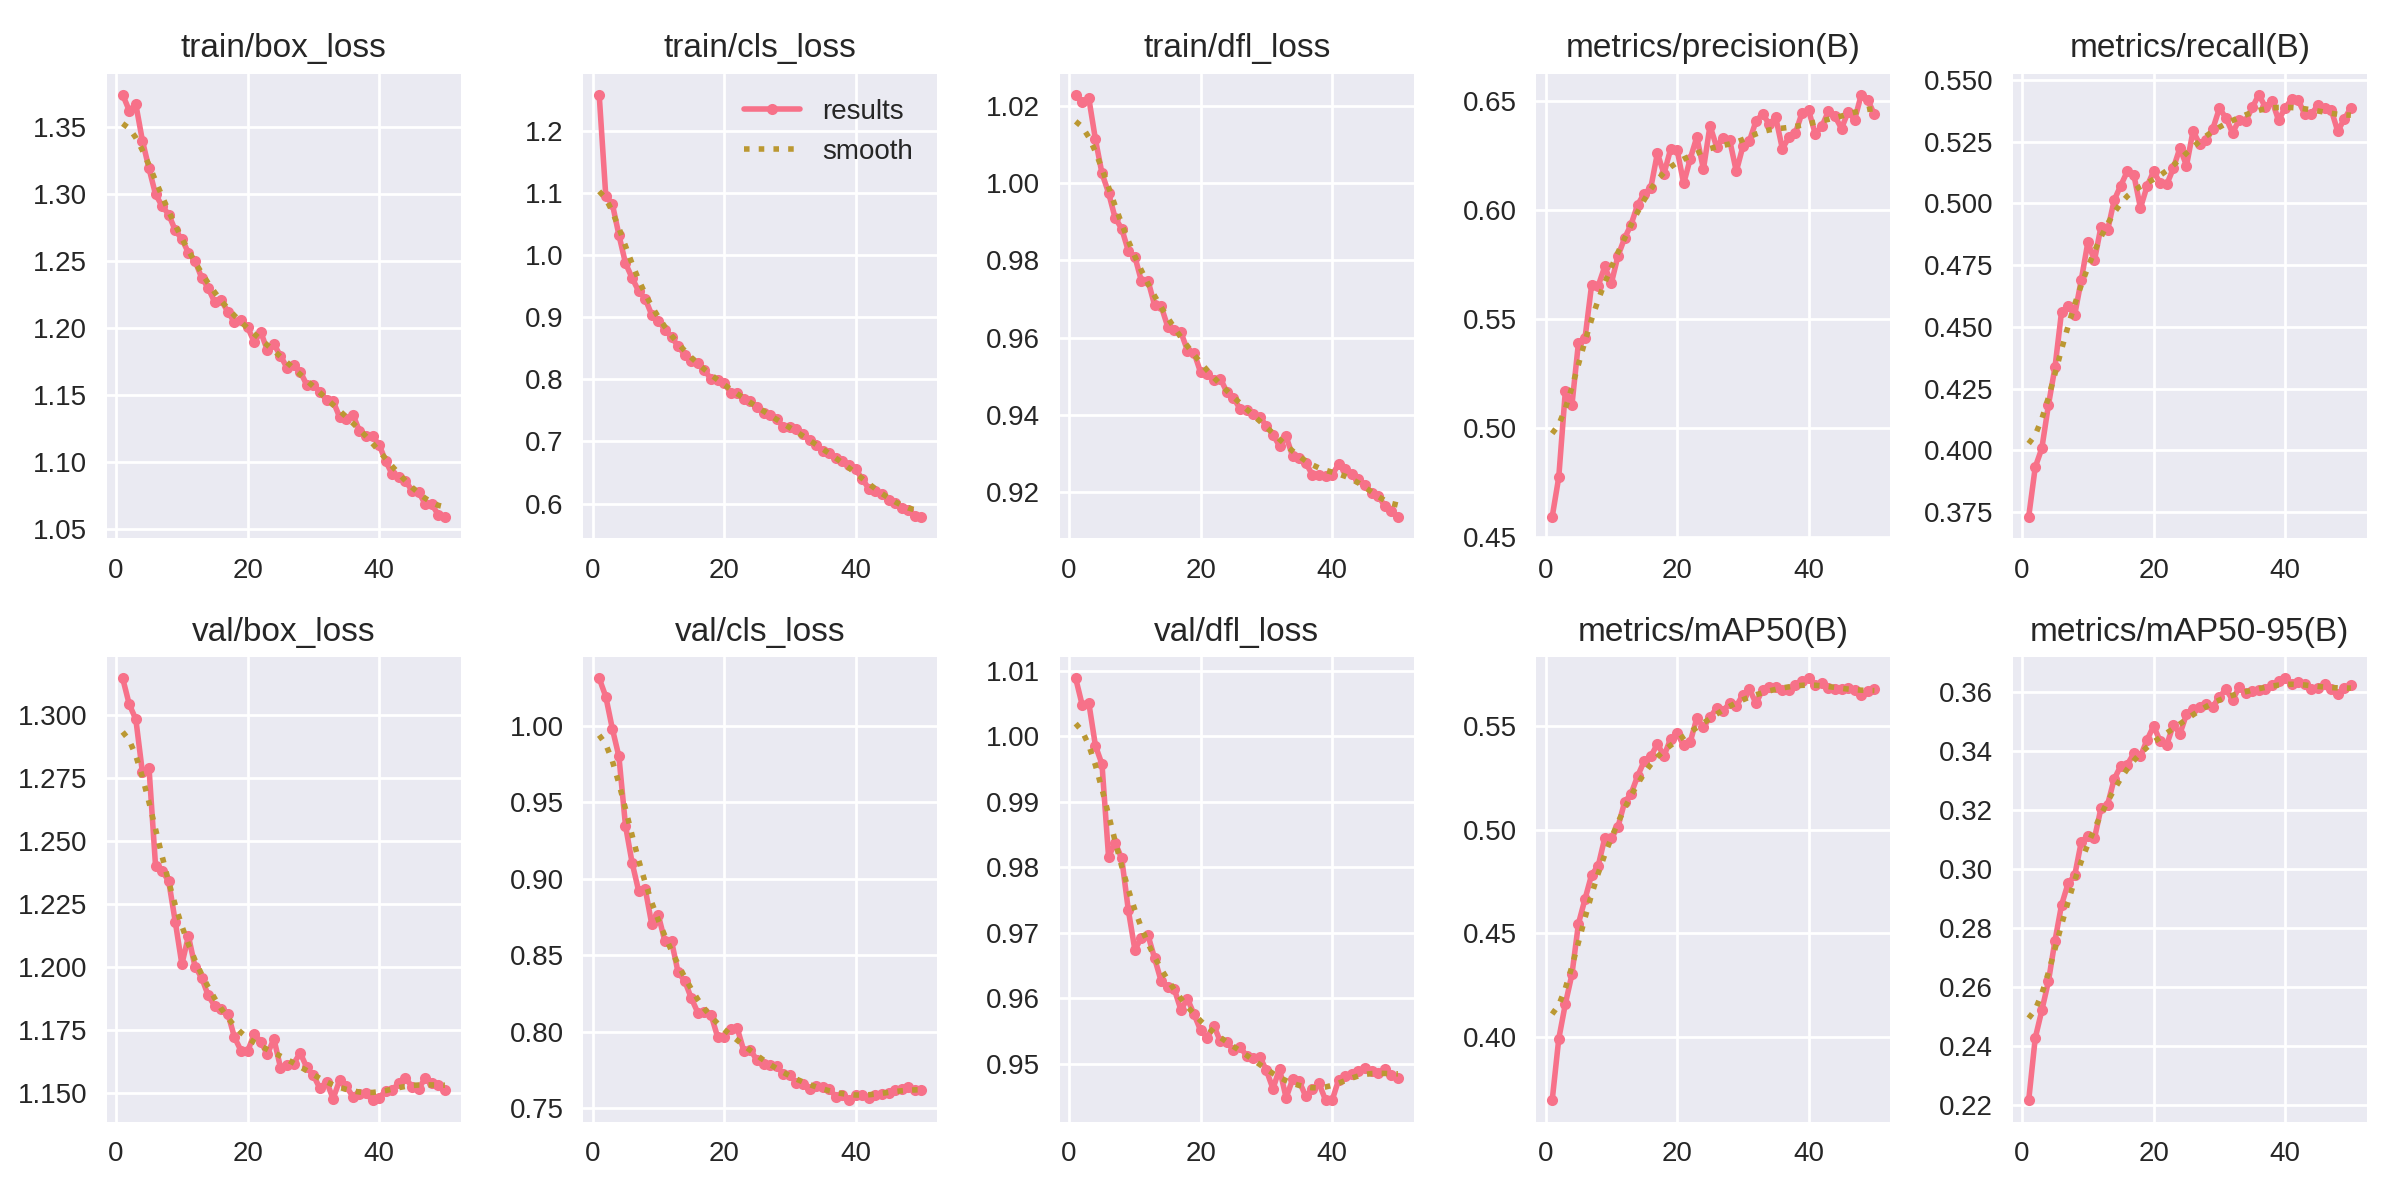

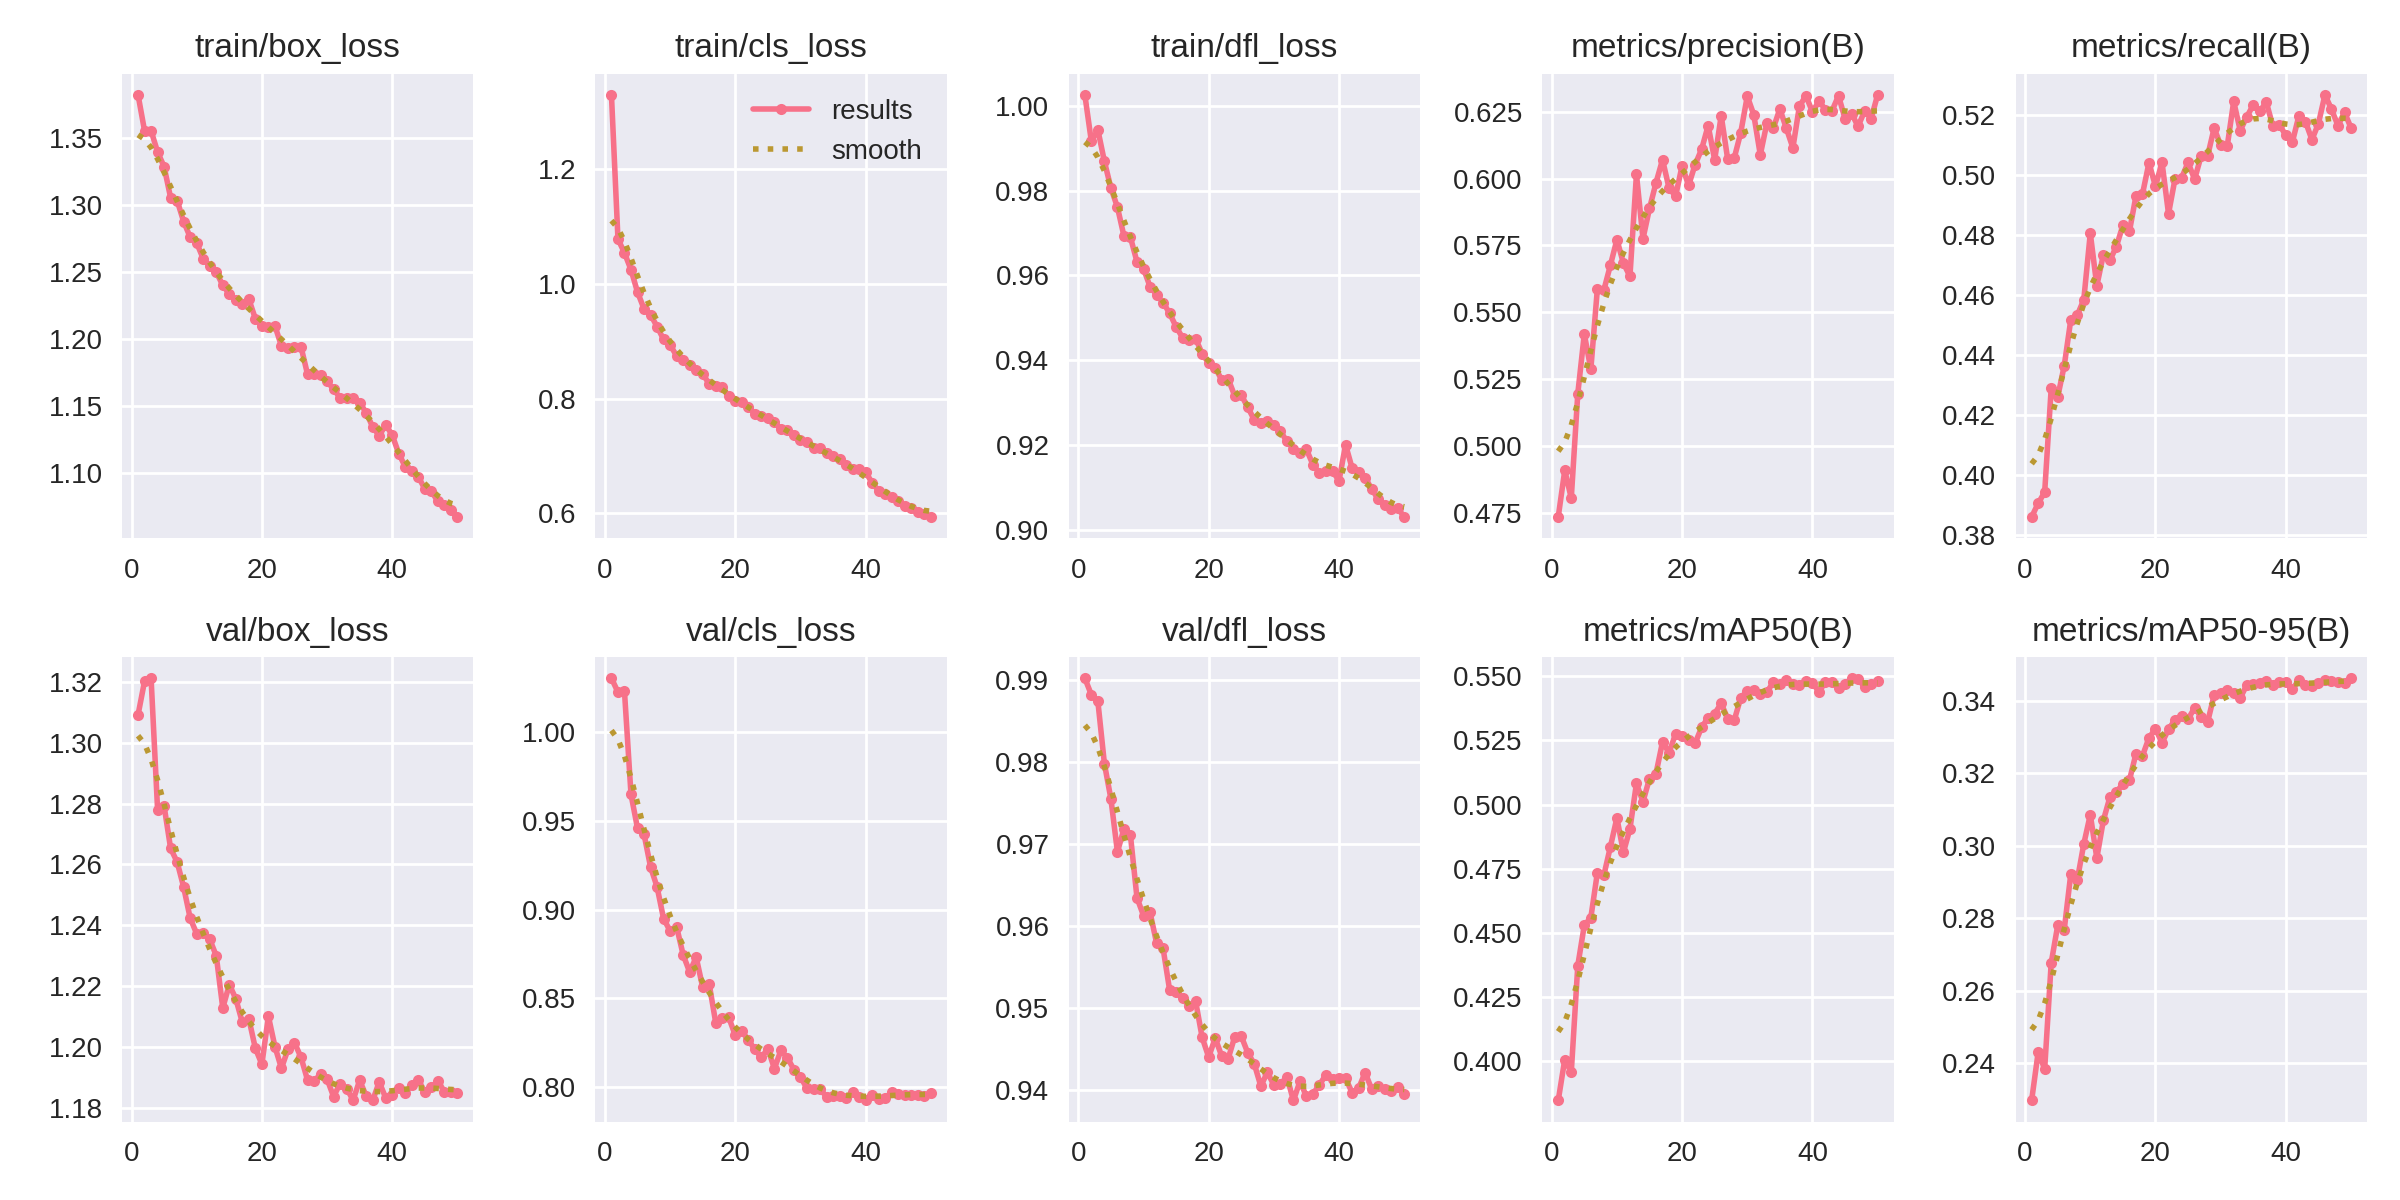

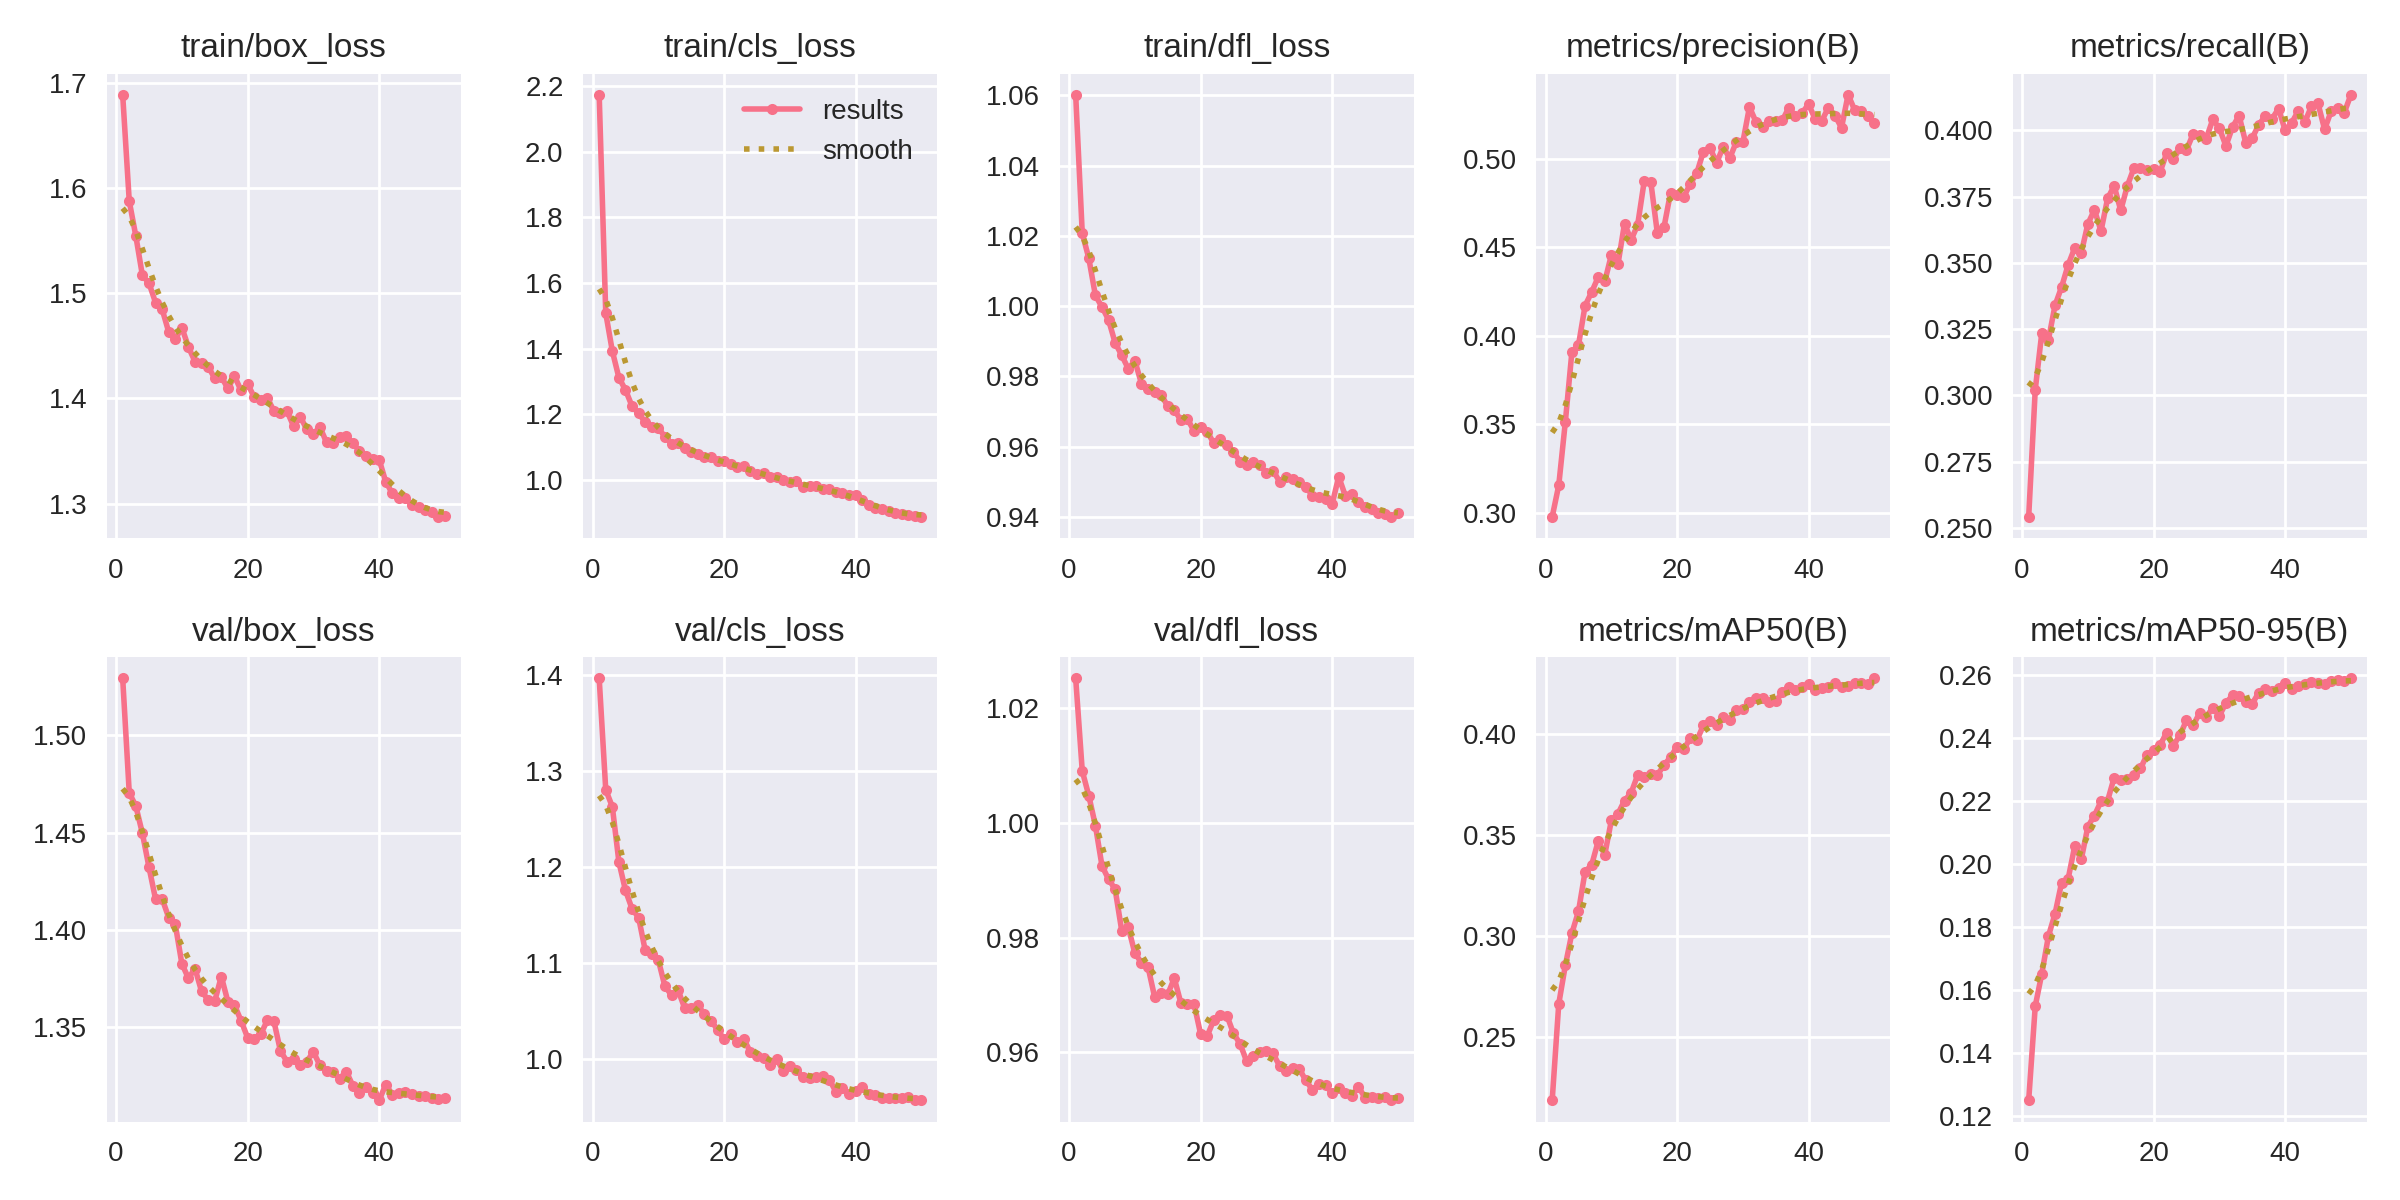

Проверка скорости инференса (CPU/GPU) на реальных картинках

In [32]:
import time
from pathlib import Path
import numpy as np

VAL_IMAGES = Path("data/datasets/visdrone/VisDrone2019-DET-val/VisDrone2019-DET-val/images")
img_paths = sorted([p for p in VAL_IMAGES.glob("*.*")])[:30]

def benchmark(model, imgsz=1024):
    times = []
    for p in img_paths:
        t0 = time.perf_counter()
        _ = model.predict(source=str(p), imgsz=imgsz, conf=0.25, iou=0.45, verbose=False)
        times.append(time.perf_counter() - t0)
    times = np.array(times)
    return float(times.mean()), float(np.percentile(times, 95))

for name, model in models.items():
    mean_t, p95_t = benchmark(model, imgsz=1024)
    print(f"{name}: mean={mean_t:.3f}s, p95={p95_t:.3f}s, N={len(img_paths)}")

yolov8n: mean=0.030s, p95=0.053s, N=30
yolov8m: mean=0.031s, p95=0.042s, N=30
yolov8l: mean=0.037s, p95=0.044s, N=30


yolov8n: mean=0.030s, p95=0.053s, N=30 <br>
yolov8m: mean=0.031s, p95=0.042s, N=30 <br>
yolov8l: mean=0.037s, p95=0.044s, N=30 <br>

Санити-чек

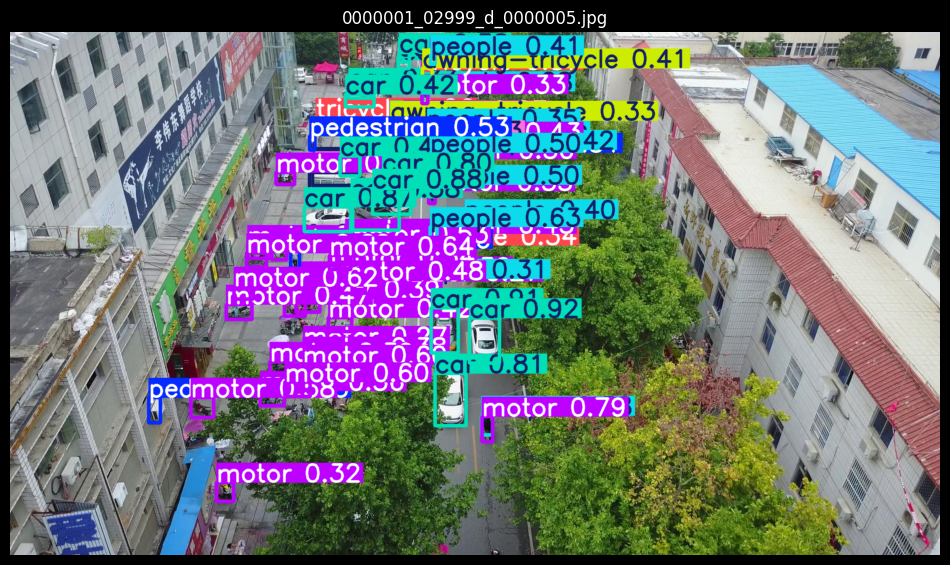

In [33]:
import matplotlib.pyplot as plt

p = img_paths[0]
r = models["yolov8n"].predict(source=str(p), imgsz=1024, conf=0.25, iou=0.45, verbose=False)[0]
img = r.plot()  # numpy array (BGR)

plt.figure(figsize=(12, 8))
plt.imshow(img[..., ::-1])  # BGR -> RGB
plt.axis("off")
plt.title(p.name)
plt.show()

# 8. Заключение и использование

In [17]:
# Пример использования
print("Пример запуска пайплайна:")
print("""
# 1. Загрузите и подготовьте данные
# data_yaml = 'data/datasets/visdrone/data.yaml'

# 2. Запустите полный пайплайн
# results = run_full_pipeline(data_yaml)

# 3. Используйте лучшую модель для инференса
# if results:
#     best_model_name = results['best_model']
#     best_model = results['trained_models'][best_model_name]['model']
#     
#     # Детекция на новом изображении
#     test_results = best_model('path/to/your/image.jpg')
#     test_results[0].show()
""")

Пример запуска пайплайна:

# 1. Загрузите и подготовьте данные
# data_yaml = 'data/datasets/visdrone/data.yaml'

# 2. Запустите полный пайплайн
# results = run_full_pipeline(data_yaml)

# 3. Используйте лучшую модель для инференса
# if results:
#     best_model_name = results['best_model']
#     best_model = results['trained_models'][best_model_name]['model']
#     
#     # Детекция на новом изображении
#     test_results = best_model('path/to/your/image.jpg')
#     test_results[0].show()



## Следующие шаги:

1. **Загрузите датасет VisDrone** используя Kaggle API
2. **Настройте конфигурацию данных** в `data/datasets/visdrone/data.yaml`
3. **Запустите обучение** вызвав `train_all_models('data/datasets/visdrone/data.yaml')`
4. **Проанализируйте результаты** используя функции оценки
5. **Экспортируйте модели** для использования в production
6. **Интегрируйте лучшую модель** с backend системой

## Примечания:

- Для обучения требуется GPU с достаточным объемом памяти
- Обучение YOLOv8l может занять несколько часов
- Рекомендуется начать с YOLOv8n для быстрого прототипирования
- Все результаты сохраняются в директории `data/results/`
- Экспортированные модели сохраняются в `exported_models/`

## Следующие шаги:

1. **Загрузите датасет VisDrone** используя Kaggle API
2. **Настройте конфигурацию данных** в `data/datasets/visdrone/data.yaml`
3. **Запустите обучение** вызвав `train_all_models('data/datasets/visdrone/data.yaml')`
4. **Проанализируйте результаты** используя функции оценки
5. **Экспортируйте модели** для использования в production
6. **Интегрируйте лучшую модель** с backend системой

## Примечания:

- Для обучения требуется GPU с достаточным объемом памяти
- Обучение YOLOv8l может занять несколько часов
- Рекомендуется начать с YOLOv8n для быстрого прототипирования
- Все результаты сохраняются в директории `data/results/`
- Экспортированные модели сохраняются в `exported_models/`